In [1]:
import csv
import pandas as pd
import clip
import torch
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from image_database import *
from PIL import Image
from scipy.spatial.distance import cdist
import bisect 
from scipy.spatial import ConvexHull
import gc
import debias_clip as dclip
#import cvxpy as cp
image_folder_prefix = 'datasets/occupations_2/images/'

data = pd.read_csv('datasets/occupations_2/occupations_labels.csv') #datasets\occuptations_2\occupations_labels.csv



In [2]:
## Preprocessing

extract_term = lambda x: x.split('/')[0]
data['search_term'] = data['location'].apply(extract_term)

catagories = data['search_term'].unique()
define_path = lambda x: image_folder_prefix + x 
data['image_relative_path'] = data['location'].apply(define_path)

flawed_images = ["PR person/000056.jpg", "mail carrier/000067.jpg"]

data.drop(data[data['location'].isin(flawed_images)].index, inplace = True)

true_rate_women = {}
true_rate_dark = {}

for cat in catagories:
    data_in_cat = data[data['search_term'] == cat]
    true_rate_women[cat] = data_in_cat[data_in_cat['gender'] == 'Female'].count()[0]/data_in_cat.count()[0]
    true_rate_dark[cat] = data_in_cat[data_in_cat['skintone'] == 'dark'].count()[0]/data_in_cat.count()[0]
    data.loc[data['search_term'] == cat, 'search_p_women'] = true_rate_women[cat]
    data.loc[data['search_term'] == cat, 'search_p_dark'] = true_rate_dark[cat]

In [3]:
data.head(10)


location gender skintone        search_term  \
0  garbage collector/000001.jpg   Male     dark  garbage collector   
1  garbage collector/000002.jpg   Male    light  garbage collector   
2  garbage collector/000003.jpg   Male     dark  garbage collector   
3  garbage collector/000004.jpg   Male     dark  garbage collector   
4  garbage collector/000005.jpg   Male     dark  garbage collector   
5  garbage collector/000006.jpg    NaN      NaN  garbage collector   
6  garbage collector/000007.jpg    NaN      NaN  garbage collector   
7  garbage collector/000008.jpg   Male    light  garbage collector   
8  garbage collector/000009.jpg   Male     dark  garbage collector   
9  garbage collector/000010.jpg   Male     dark  garbage collector   

                                 image_relative_path  search_p_women  \
0  datasets/occupations_2/images/garbage collecto...            0.08   
1  datasets/occupations_2/images/garbage collecto...            0.08   
2  datasets/occupations_2/images/garbage collecto...            0.08   
3  datasets/occupations_2/images/garbage collecto...            0.08   
4  datasets/occupations_2/images/garbage collecto...            0.08   
5  datasets/occupations_2/images/garbage collecto...            0.08   
6  datasets/occupations_2/images/garbage collecto...            0.08   
7  datasets/occupations_2/images/garbage collecto...            0.08   
8  datasets/occupations_2/images/garbage collecto...            0.08   
9  datasets/occupations_2/images/garbage collecto...            0.08   

   search_p_dark  
0           0.15  
1           0.15  
2           0.15  
3           0.15  
4           0.15  
5           0.15  
6           0.15  
7           0.15  
8           0.15  
9           0.15

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)

batch_size = 200

if True:
    features = process_images(model, preprocess, data['image_relative_path'], batch_size=batch_size)



 17%|█▋        | 8/48 [00:38<03:05,  4.64s/it]c:\Anaconda\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 48/48 [04:39<00:00,  5.82s/it]


In [4]:
device_d = "cuda" if torch.cuda.is_available() else "cpu"
model_debias, preprocess_debias = dclip.load("ViT-B/16-gender", device_d)

batch_size = 200

features_debias = process_images(model_debias, preprocess_debias, data['image_relative_path'], batch_size=batch_size, device=device_d)

device_d = 'cpu'
model_debias, preprocess_debias = dclip.load("ViT-B/16-gender", device_d)

Installing pretrained embedings
 best_ndkl_oai-clip-vit-b-16_neptune_run_OXVLB-317_model_e4_step_5334_embeddings.pt...


100%|█████████████████████████████████████| 4.73k/4.73k [00:00<00:00, 4.86MiB/s]
100%|██████████| 48/48 [05:42<00:00,  7.14s/it]


Installing pretrained embedings
 best_ndkl_oai-clip-vit-b-16_neptune_run_OXVLB-317_model_e4_step_5334_embeddings.pt...


100%|█████████████████████████████████████| 4.73k/4.73k [00:00<00:00, 2.43MiB/s]


In [6]:
print(features)

np.save('datasets/occupations_2/embeddings_of_labelled_images.npy', features)

if False:
    features = np.load('datasets/occupations_2/embeddings_of_labelled_images.npy')


[[ 0.0842   0.533   -0.0644  ...  0.9097   0.05615 -0.00886]
 [-0.306    0.3274   0.2013  ...  0.8115  -0.2      0.2605 ]
 [ 0.0686   0.1488   0.101   ...  0.486    0.1422   0.331  ]
 ...
 [ 0.3772  -0.1936   0.297   ...  0.7603   0.0554  -0.0834 ]
 [-0.223   -0.1492   0.4485  ...  0.6636   0.0761   0.1573 ]
 [-0.01723 -0.2815  -0.1882  ...  0.2216   0.458   -0.02133]]


In [9]:
"""class ImageDatabase():
    def __init__(self, features, data, model, preprocess, device="cuda"):
        if device == "cuda": self.arraytype = torch.float16 
        else: self.arraytype = torch.float32
        self.features = t_normalize(torch.tensor(features).to(device)).to(self.arraytype)
        self.data = data
        self.model = model
        self.preprocess = preprocess
        self.device = device
        self.clipclip_orderings = {}

    def _process_query(self, query):
        token = clip.tokenize(query).to(self.device)
        #print(token.device)
        with torch.no_grad():
            query_features = t_normalize(self.model.encode_text(token))
        return query_features
        
    def search(self, query, k=10, **kwargs):
        query_features = self._process_query(query)
        similarities = (self.features @ query_features.T).flatten()
        best = similarities.argsort(descending=True).cpu().flatten()
        return self.data.iloc[best[:k]]
    
    def sensitive_attributes(self, paired_attributes):
        l_attr = list(sum(paired_attributes, ()))
        tokens = clip.tokenize(l_attr).to(self.device)
        with torch.no_grad():
            attributes_features = t_normalize(self.model.encode_text(tokens))
        self.sensitive_ideals = attributes_features.reshape(len(paired_attributes), 2, -1)

        return self
        
    def _calc_sim_set(self, best, similarities, k, max_sim_set, tol):
        sim = similarities[best]
        sim_top_k_avg = sim[0:k].mean()
        for i in range(len(sim)):
            if sim[i] < sim_top_k_avg - tol:
                break
        k = min(max(k, i), max_sim_set)
        return best[0:k]


    def _get_sim_to_ideal(self, entries):
        sim_set_features = self.features[entries]
        sim = torch.matmul(self.sensitive_ideals, sim_set_features.T)
        proba = (100 * sim).permute(2, 0, 1).softmax(dim=-1)[:, :, 0].to('cpu').numpy()
        return proba

    def _retrieve_distinct(self, sim_set, similarities, k, mode='max_sum'):
        proba_concepts = self._get_sim_to_ideal(sim_set)
        vals = proba_concepts
        pca = PCA()
        
        if mode == 'max_sum': 
            VI=np.cov(vals, rowvar=False)
            sim_set_edit = sim_set.detach().clone().numpy()
            p_indices = [sim_set_edit[0]]
            sim_set_edit = np.delete(sim_set_edit, 0)
            p = [vals[0]]
            vals = np.delete(vals, 0, axis=0)

            distances = cdist(vals, p, 'mahalanobis', VI=VI)

            while len(p) < k:
                mean_distances = np.mean(distances, axis=1)
                max_sum = np.argmax(mean_distances)
                maximally_away = max_sum
                p_indices.append(sim_set_edit[maximally_away])
                p.append(vals[maximally_away])
                distances = np.hstack((distances, cdist(vals, [vals[maximally_away]], 'mahalanobis', VI=VI)))
                sim_set_edit = np.delete(sim_set_edit, maximally_away)
                vals = np.delete(vals, maximally_away, axis=0)
                distances = np.delete(distances, maximally_away, axis=0)

        if mode == 'max_min':
            VI=np.cov(vals, rowvar=False)
            sim_set_edit = sim_set.detach().clone().numpy()
            p_indices = [sim_set_edit[0]]
            sim_set_edit = np.delete(sim_set_edit, 0)
            p = [vals[0]]
            vals = np.delete(vals, 0, axis=0)

            distances = cdist(vals, p, 'mahalanobis', VI=VI)

            while len(p) < k:
                min_distances = np.min(distances, axis=1)
                max_min = np.argmax(min_distances)
                maximally_away = max_min
                p_indices.append(sim_set_edit[maximally_away])
                p.append(vals[maximally_away])
                distances = np.hstack((distances, cdist(vals, [vals[maximally_away]], 'mahalanobis', VI=VI)))
                sim_set_edit = np.delete(sim_set_edit, maximally_away)
                vals = np.delete(vals, maximally_away, axis=0)
                distances = np.delete(distances, maximally_away, axis=0)

        if mode == 'random':
            p_indices = np.random.choice(sim_set, k, replace = False)
            
            
        if mode == "feature_distances":
            vals = torch.index_select(self.features, 0, sim_set.to(self.device)).cpu().numpy()
            sim_set_edit = sim_set.detach().clone().numpy()
            p_indices = [sim_set_edit[0]]
            sim_set_edit = np.delete(sim_set_edit, 0)
            p = [vals[0]]
            vals = np.delete(vals, 0, axis=0)

            distances = cdist(vals, p, 'cosine')

            while len(p) < k:
                mean_distances = np.mean(distances, axis=1)
                max_sum = np.argmax(mean_distances)
                maximally_away = max_sum
                p_indices.append(sim_set_edit[maximally_away])
                p.append(vals[maximally_away])
                distances = np.hstack((distances, cdist(vals, [vals[maximally_away]], 'cosine')))
                sim_set_edit = np.delete(sim_set_edit, maximally_away)
                vals = np.delete(vals, maximally_away, axis=0)
                distances = np.delete(distances, maximally_away, axis=0)

        if mode == 'true_labels':
            vals = self._get_true_coordinates(sim_set)
            VI=np.cov(vals, rowvar=False)
            sim_set_edit = sim_set.detach().clone().numpy()
            p_indices = [sim_set_edit[0]]
            sim_set_edit = np.delete(sim_set_edit, 0)
            p = [vals[0]]
            vals = np.delete(vals, 0, axis=0)

            distances = cdist(vals, p, 'mahalanobis', VI=VI)

            while len(p) < k:
                mean_distances = np.mean(distances, axis=1)
                max_sum = np.argmax(mean_distances)
                maximally_away = max_sum
                p_indices.append(sim_set_edit[maximally_away])
                p.append(vals[maximally_away])
                distances = np.hstack((distances, cdist(vals, [vals[maximally_away]], 'mahalanobis', VI=VI)))
                sim_set_edit = np.delete(sim_set_edit, maximally_away)
                vals = np.delete(vals, maximally_away, axis=0)
                distances = np.delete(distances, maximally_away, axis=0)

        return p_indices
    
    def define_coordinate_mapping(self, columns, positive_labels, negative_labels):
        self.true_coordinates = np.zeros((len(self.data), len(columns)))
        self.coord_columns = columns
        for i, column in enumerate(columns):
            map_to_hypercube = lambda x: 1 if x in positive_labels[i] else (0 if x in negative_labels[i] else .5)
            self.true_coordinates[:, i] = self.data[column].apply(map_to_hypercube)
    
    def _get_true_coordinates(self, sim_set):
        return self.true_coordinates[sim_set] 

    
    def distinct_retrival(self, query, k=10, max_sim_set=1000, tol=.06, method='max_sum', **kwargs) :
        query_features = self._process_query(query)

        similarities = (self.features @ query_features.T).flatten()
        best = similarities.argsort(descending=True).cpu().flatten()

        sim_set = self._calc_sim_set(best, similarities, k, max_sim_set, tol)
        distinct_sort = self._retrieve_distinct(sim_set, similarities, k, mode=method)


        return self.data.iloc[distinct_sort]

    def define_pbm_classes(self, classes):
        self.pbm_classes=classes
        prompts = [f"A picture of a {c}." for c in classes]
        if classes[0] == "empty":
            prompts[0] == ""
        tokens = clip.tokenize(prompts).to(self.device)
        with torch.no_grad():
            attributes_features = t_normalize(self.model.encode_text(tokens))
        self.pbm_ideals = attributes_features
        self.pbm_label = np.argmax((100 * torch.matmul(self.features, self.pbm_ideals.T)).softmax(dim=-1).to('cpu').numpy(), axis=-1)

        return self

    def pbm(self, query, k=10, eps=0, **kwargs):
        query_features = self._process_query(query)
        similarities = (self.features @ query_features.T).flatten()
        best = similarities.argsort(descending=True).cpu().numpy().flatten()
        np_sim = similarities.cpu().numpy()

        p_indices = []

        neutrals = [x for x in best if self.pbm_label[x] == 0]
        classes = [[x for x in best if self.pbm_label[x]== i] for i in range(1, len(self.pbm_classes))]

    
        while len(p_indices) < k:
            if random.random() < eps:
                try:
                    neutral_sim = np_sim[neutrals[0]]
                except:
                    neutral_sim = -1
                
                max_class, idx = 0, 0
                for i, c in enumerate(classes):
                    try:
                        class_sim = np_sim[c[0]]
                    except:
                        class_sim = -1
                    if class_sim > max_class:
                        max_class = class_sim
                        idx = i
                if max_class > neutral_sim:
                    p_indices.append(classes[idx][0])
                    classes[idx].pop(0)
                else:
                    p_indices.append(neutrals[0])
                    neutrals.pop(0)
                        
            else:
                best_neutral = neutrals[0]
                best_for_classes = [fon(c) for c in classes]
                best_for_classes_vals = [c for c in best_for_classes if c is not None]

                similarities_for_classes = [np_sim[x] for x in best_for_classes_vals]
                avg_sim = np.mean(similarities_for_classes)
                neutral_sim = similarities[best_neutral]

                if avg_sim > neutral_sim:
                    if len(p_indices) + len(best_for_classes_vals) > k:
                        best_for_classes_vals = random.choices(best_for_classes_vals, k=k-len(p_indices))
                    p_indices += best_for_classes_vals

                    for i, x in enumerate(best_for_classes):
                        if x is not None:
                            classes[i].pop(0)
                else:
                    p_indices.append(best_neutral)
                    neutrals.pop(0)
        
        return self.data.iloc[p_indices]

    def add_clipclip_ordering(self, name, ordering):
        self.clipclip_orderings[name] = ordering.copy()
        return self
    
    def clip_clip(self, query, ordering, n_to_clip, k=10, **kwargs):
        query_features = self._process_query(query)
        clip_ordering = self.clipclip_orderings[ordering]
        clip_features = torch.index_select(self.features, 1, torch.tensor(clip_ordering[n_to_clip:]).to(self.device))
        clip_query = torch.index_select(query_features, 1, torch.tensor(clip_ordering[n_to_clip:]).to(self.device))

        similarities = (clip_features @ clip_query.T).flatten()
        best = similarities.argsort(descending=True).cpu().flatten()
        return self.data.iloc[best[:k]]"""




In [25]:
image_database = ImageDatabase(features, data, model, preprocess, device)
#image_database.sensitive_attributes([("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of a young person", "A picture of an old person")])
print(image_database.features.dtype)
print(image_database.search("This is a picture of a engineer."))
#print(image_database.distinct_retrival("This is a picture of a pilot."))

print(image_database._process_query("This is a picture of a engineer.").dtype)

image_database.define_pbm_classes(["unknown gender", "man", "woman"])
print(image_database.pbm("This is a picture of a customer service representative.", eps=.8))

debias_database = ImageDatabase(features_debias, data, model_debias, preprocess_debias, device_d)
#debias_database.search("This is a picture of a engineer.")


#print(debias_database.features.dtype)
#print(debias_database._process_query("This is a picture of a engineer.").dtype)

#print(debias_database.features @ debias_database._process_query("This is a picture of a engineer.").T)

torch.float16
                            location gender skintone          search_term  \
8764  construction worker/000065.jpg   Male    light  construction worker   
8710  construction worker/000011.jpg    NaN      NaN  construction worker   
8744  construction worker/000045.jpg   Male    light  construction worker   
1839             engineer/000040.jpg   Male    light             engineer   
8709  construction worker/000010.jpg   Male     dark  construction worker   
1867             engineer/000068.jpg   Male    light             engineer   
842    building inspector/000043.jpg   Male    light   building inspector   
8447            custodian/000048.jpg   Male    light            custodian   
5454          electrician/000055.jpg   Male    light          electrician   
2063              plumber/000064.jpg   Male    light              plumber   

                                    image_relative_path  search_p_women  \
8764  datasets/occupations_2/images/construction wor...        

In [6]:

def run_analysis(method_call, k, tol, result_dict, catagories, catagorical_column, label_indistinguishable_values_list, protected_columns, protected_positive_values, protected_negative_values, true_rates, totals_by_cat, prefix="This is a picture of a"):
    result_dict['k'] = k
    result_dict['tol'] = tol
    result_dict['precision'] = np.zeros(len(catagories))
    result_dict['precision_up_to_indistinguishablity'] = np.zeros(len(catagories))
    result_dict['recall'] = np.zeros(len(catagories))
    result_dict['bias'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['abs_bias'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['skew'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['bias_for_accurate'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['abs_bias_for_accurate'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['skews_for_accurate'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['max_skew'] = np.zeros(len(catagories))
    result_dict['min_skew'] = np.zeros(len(catagories))
    result_dict['worst_multiclass_error'] = np.zeros(len(catagories))



    for i, cat in enumerate(catagories):
        res = method_call(f"{prefix} {cat}")
        result_dict['precision'][i] = precision(label_column=catagorical_column, positive_label_value=cat, data=res)
        result_dict['precision_up_to_indistinguishablity'][i] = precision_up_to_indistinguishablity(label_column=catagorical_column, indistinguishable_labels=label_indistinguishable_values_list[i], data=res)
        result_dict['recall'][i] = recall(label_column=catagorical_column, positive_label_value=cat, data=res, total_positive=totals_by_cat[cat])
        biases = np.zeros(len(protected_columns))
        skews = np.zeros(len(protected_columns))
        abs_biases = np.zeros(len(protected_columns))
        biases_for_accurate = np.zeros(len(protected_columns))
        abs_biases_for_accurate = np.zeros(len(protected_columns))
        skews_for_accurate = np.zeros(len(protected_columns))

        for j, (protected_col, protected_pos_vals, protected_neg_vals) in enumerate(zip(protected_columns, protected_positive_values, protected_negative_values)):
            abs_bias, abs_bias_in_correct_retrievals = abs_bias_in_retrieval(label_column=catagorical_column, positive_label_values=[cat], data=res, protected_column=protected_col, protected_positive_values=protected_pos_vals, protected_negative_values=protected_neg_vals)
            bias, bias_in_correct_retrievals = bias_in_retrieval(label_column=catagorical_column, positive_label_values=[cat], data=res, protected_column=protected_col, protected_positive_values=protected_pos_vals, protected_negative_values=protected_neg_vals)
            biases[j] = bias
            biases_for_accurate[j] = bias_in_correct_retrievals
            abs_biases[j] = abs_bias
            abs_biases_for_accurate[j] = abs_bias_in_correct_retrievals
            skew, skew_for_accurate = skew_in_retrieval(label_column=catagorical_column, positive_label_values=[cat], data=res, protected_column=protected_col, protected_positive_values=protected_pos_vals, true_rate=true_rates[j][i])
            skews[j] = skew
            skews_for_accurate[j] = skew_for_accurate
        
        result_dict['bias'][i] = biases
        result_dict['abs_bias'][i] = abs_biases
        result_dict['skew'][i] = skews
        result_dict['bias_for_accurate'][i] = biases_for_accurate
        result_dict['abs_bias_for_accurate'][i] = abs_biases_for_accurate
        result_dict['skews_for_accurate'][i] = skews_for_accurate
        result_dict['max_skew'][i] = max(skews)
        result_dict['min_skew'][i] = min(skews)
        result_dict['worst_multiclass_error'][i] = multiclass_bias_in_retrieval(label_column=catagorical_column, positive_label_values=[cat], data=res, protected_columns=protected_columns, protected_positive_values=protected_positive_values, protected_negative_values=protected_negative_values)

    return result_dict

def parse_analysis(result_dicts, protected_column_names):
    data = []
    for result in result_dicts:
        parsed_result = {}
        if result['tol'] is not None:
            if result['name'][0:3] == "PBM":
                parsed_result['method'] = result['name'] + "(eps " + str(result['tol']) + ")"
            parsed_result['method'] = result['name'] + " (tol: " + str(result['tol']) + ")"
        else:
            parsed_result['method'] = result['name']
        parsed_result['name'] = result['name']
        parsed_result['tol'] = result['tol']
        parsed_result['k'] = result['k']
        parsed_result['Avg_Precision'] = np.mean(result['precision'])
        parsed_result['Avg_Recall'] = np.mean(result['recall'])
        parsed_result['Avg_PutI'] = np.mean(result['precision_up_to_indistinguishablity'])

        for i, protected_col in enumerate(protected_column_names):
            parsed_result[f'Avg_AbsBias_{protected_col}'] = np.mean(result['abs_bias'][:,i])
            parsed_result[f'Avg_Bias_{protected_col}'] = np.mean(result['bias'][:,i])
            parsed_result[f'Avg_Skew_{protected_col}'] = np.mean(result['skew'][:,i])
            parsed_result[f'Avg_Abs_Skew_{protected_col}'] = np.mean(np.abs(result['skew'][:,i]))
            parsed_result[f'Avg_AbsBias_for_Accurate_{protected_col}'] = np.mean(result['abs_bias_for_accurate'][:,i])

        parsed_result['Avg_Max_MC_Bias'] =np.mean(result['worst_multiclass_error'])

        if len(protected_column_names) > 1:
            parsed_result['Max_AbsBias'] = np.max([np.mean(result['abs_bias'][:,i]) for i in range(len(protected_column_names))])

        data.append(parsed_result.copy())

    df = pd.DataFrame(data)
    return df


image_database = ImageDatabase(features, data, model, preprocess, device)
image_database.sensitive_attributes([("A picture of a man", "A picture of a woman"), ("A picture of a white person", "A picture of a black person")]) #
image_database.define_pbm_classes(["unknown gender", "man", "woman"])

baseline_metrics = {'name': 'Baseline'}
random_from_similar_set_metrics = {'name': 'RandomSS'}
divimage_max_sum_metrics = {'name': 'DivImageMSum'}
divimage_max_min_metrics = {'name': 'DivImageMMin'}
#diviamge_clustering_metrics = {'name': 'DivImageC'}
#divimage_qp_metrics = {'name': 'DivImageQP'}
random_from_similar_set_metrics_larger_tol = {'name': 'RandomSS'}
divimage_max_sum_metrics_larger_tol = {'name': 'DivImageMSum'}
divimage_max_min_metrics_larger_tol = {'name': 'DivImageMMin'}
pbm_metrics_gender = {'name': 'PBM_Gender'}
pbm_metrics_skintone = {'name': 'PBM_skintone'}
pbm_intersectional_metrics = {'name': 'PBM_Intersectional'}
pbm_intersectional_with_age_metrics = {'name': 'PBM_Intersectional_Age'}
debias_clip_metrics = {'name': 'DebiasClip'}


indistinguisable_values = [[cat] for cat in catagories]
totals_by_cat = {cat: len(data[data['search_term'] == cat]) for cat in catagories}
true_rates = [[data[data['search_term'] == cat].iloc[0].search_p_women for cat in catagories], [data[data['search_term'] == cat].iloc[0].search_p_dark for cat in catagories]]

print(true_rates)

#run_analysis(lambda x: image_database.search(x, 25), 25, None, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['gender'], [['Female']], [['Male']], true_rates)
#df = parse_analysis([baseline_metrics], ['gender'])
#print(df)

run_analysis(lambda x: image_database.search(x, 25), 25, None, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.02, method='max_sum'), 25, .02, divimage_max_sum_metrics, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.02, method='max_min'), 25, .02, divimage_max_min_metrics, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.02, method='random'), 25, .02, random_from_similar_set_metrics, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.04, method='max_sum'), 25, .04, divimage_max_sum_metrics_larger_tol, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.04, method='max_min'), 25, .04, divimage_max_min_metrics_larger_tol, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.04, method='random'), 25, .04, random_from_similar_set_metrics_larger_tol, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
## Add with age
## Add with age


image_database.define_pbm_classes(["unknown gender", "man", "woman"])
run_analysis(lambda x: image_database.pbm(x, 25, eps=0), 25, None, pbm_metrics_gender, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
image_database.define_pbm_classes(["unknown skin-tone", "light-skinned person", "dark-skinned person"])
run_analysis(lambda x: image_database.pbm(x, 25, eps=0), 25, None, pbm_metrics_skintone, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
image_database.define_pbm_classes(["unknown gender and skin-tone", "light-skinned man", "light-skinned woman", "dark-skinned man", "dark-skinned woman"])
run_analysis(lambda x: image_database.pbm(x, 25, eps=0), 25, None, pbm_intersectional_metrics, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
image_database.define_pbm_classes(["unknown gender and skin-tone", "light-skinned old man", "light-skinned old woman", "dark-skinned old man", "dark-skinned old woman", "light-skinned young man", "light-skinned young woman", "dark-skinned young man", "dark-skinned young woman"])
run_analysis(lambda x: image_database.pbm(x, 25, eps=0), 25, None, pbm_intersectional_with_age_metrics, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)

#run_analysis(lambda x: debias_database.search(x, 25), 25, None, debias_clip_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates)

df = parse_analysis([baseline_metrics, divimage_max_sum_metrics, divimage_max_min_metrics, random_from_similar_set_metrics, divimage_max_sum_metrics_larger_tol, divimage_max_min_metrics_larger_tol, random_from_similar_set_metrics_larger_tol, pbm_metrics_gender, pbm_metrics_skintone, pbm_intersectional_metrics, pbm_intersectional_with_age_metrics], ['gender', 'skintone']) #debias_clip_metrics

"""plt.hist(baseline_metrics['precision'] - divimage_metrics['precision'])
plt.show()

plt.hist(baseline_metrics['bias'] - divimage_metrics['bias'])
plt.show()"""

#print(f"Baseline Average Bias: {np.mean(baseline_metrics['bias'])}, DivImage Average Bias: {np.mean(divimage_metrics['bias'])}")

#print(divimage_metrics['bias'])
df

[[0.08, 0.56, 0.5, 0.07, 0.81, 0.16, 0.5, 0.03, 0.08, 0.06, 0.21, 0.18, 0.07, 0.53, 0.34, 0.68, 0.1, 0.53, 0.3, 0.71, 0.04, 0.33, 0.1, 0.2, 0.2, 0.33, 0.4, 0.12, 0.27, 0.15, 0.26, 0.22, 0.11, 0.08, 0.09, 0.09, 0.28, 0.03, 0.42, 0.7, 0.01, 0.32, 0.08, 0.11, 0.03, 0.67, 0.36, 0.43, 0.1, 0.09, 0.14, 0.31, 0.27, 0.27, 0.05, 0.09, 0.36, 0.14, 0.65, 0.53, 0.1, 0.26, 0.26, 0.09, 0.1, 0.40404040404040403, 0.07, 0.12, 0.01, 0.3, 0.12, 0.37, 0.05, 0.01, 0.26, 0.36, 0.11, 0.23, 0.09, 0.02, 0.34, 0.39, 0.26262626262626265, 0.07, 0.21, 0.43, 0.35, 0.08, 0.56, 0.07, 0.24, 0.51, 0.47, 0.02, 0.53, 0.45], [0.15, 0.06, 0.16, 0.01, 0.1, 0.13, 0.08, 0.13, 0.06, 0.15, 0.12, 0.06, 0.07, 0.18, 0.11, 0.15, 0.08, 0.02, 0.06, 0.08, 0.06, 0.13, 0.1, 0.06, 0.09, 0.11, 0.09, 0.06, 0.05, 0.12, 0.07, 0.04, 0.05, 0.04, 0.06, 0.16, 0.09, 0.04, 0.07, 0.15, 0.03, 0.13, 0.09, 0.3, 0.08, 0.06, 0.1, 0.03, 0.05, 0.02, 0.07, 0.1, 0.14, 0.22, 0.08, 0.09, 0.19, 0.06, 0.08, 0.25, 0.05, 0.07, 0.08, 0.05, 0.04, 0.0606060606060606

method                    name   tol   k  Avg_Precision  \
0                   Baseline                Baseline   NaN  25       0.547083   
1   DivImageMSum (tol: 0.02)            DivImageMSum  0.02  25       0.467083   
2   DivImageMMin (tol: 0.02)            DivImageMMin  0.02  25       0.492500   
3       RandomSS (tol: 0.02)                RandomSS  0.02  25       0.482500   
4   DivImageMSum (tol: 0.04)            DivImageMSum  0.04  25       0.287500   
5   DivImageMMin (tol: 0.04)            DivImageMMin  0.04  25       0.327917   
6       RandomSS (tol: 0.04)                RandomSS  0.04  25       0.322083   
7                 PBM_Gender              PBM_Gender   NaN  25       0.504167   
8               PBM_skintone            PBM_skintone   NaN  25       0.504583   
9         PBM_Intersectional      PBM_Intersectional   NaN  25       0.442917   
10    PBM_Intersectional_Age  PBM_Intersectional_Age   NaN  25       0.450417   

    Avg_Recall  Avg_PutI  Avg_AbsBias_gender  Avg_Bias_gender  \
0     0.136799  0.547083            0.478750        -0.222083   
1     0.116798  0.467083            0.283750        -0.149583   
2     0.123152  0.492500            0.320000        -0.161667   
3     0.120652  0.482500            0.467083        -0.197917   
4     0.071906  0.287500            0.128750        -0.085417   
5     0.082005  0.327917            0.174167        -0.111667   
6     0.080546  0.322083            0.421250        -0.235417   
7     0.126070  0.504167            0.154167        -0.054167   
8     0.126173  0.504583            0.479167        -0.253333   
9     0.110757  0.442917            0.264167         0.145833   
10    0.112632  0.450417            0.245000         0.040000   

    Avg_Skew_gender  Avg_Abs_Skew_gender  Avg_AbsBias_for_Accurate_gender  \
0          0.069892             0.493593                         0.474655   
1          0.463236             0.587909                         0.425648   
2          0.278537             0.465601                         0.385654   
3          0.137384             0.494496                         0.493536   
4          0.829132             0.880818                         0.431698   
5          0.458184             0.689025                         0.312768   
6          0.143194             0.512274                         0.436446   
7          0.619618             0.742798                         0.314307   
8          0.005135             0.509616                         0.477437   
9          0.866964             0.888472                         0.353161   
10         0.668052             0.702372                         0.339938   

    Avg_AbsBias_skintone  Avg_Bias_skintone  Avg_Skew_skintone  \
0               0.614167          -0.614167          -0.074334   
1               0.520417          -0.519583           0.400231   
2               0.499167          -0.499167           0.243422   
3               0.598333          -0.598333          -0.048891   
4               0.328333          -0.327500           1.111191   
5               0.352917          -0.352917           0.634182   
6               0.588750          -0.588750           0.039453   
7               0.574167          -0.574167          -0.015588   
8               0.522083          -0.521250           0.265946   
9               0.489167          -0.482500           0.383495   
10              0.493333          -0.493333           0.272164   

    Avg_Abs_Skew_skintone  Avg_AbsBias_for_Accurate_skintone  Avg_Max_MC_Bias  \
0                0.588834                           0.547621         0.538333   
1                0.624110                           0.483857         0.420000   
2                0.531511                           0.453698         0.402500   
3                0.574638                           0.513557         0.524167   
4                1.154483                           0.465924         0.269583   
5                0.741498                           0.369545    

In [10]:


image_database = ImageDatabase(features, data, model, preprocess, device)
indistinguisable_values = [[cat] for cat in catagories]
totals_by_cat = {cat: len(data[data['search_term'] == cat]) for cat in catagories}
true_rates = [[data[data['search_term'] == cat].iloc[0].search_p_women for cat in catagories], [data[data['search_term'] == cat].iloc[0].search_p_dark for cat in catagories]]
image_database.define_coordinate_mapping(['gender', 'skintone'], [['man'], ['light']], [['woman'], ['dark']])

debias_database = ImageDatabase(features_debias, data, model_debias, preprocess_debias, device_d)

image_database.add_clipclip_ordering("gender", np.load('datasets/MI_orders/gender.npy'))
image_database.add_clipclip_ordering("skintone", np.load('datasets/MI_orders/skintone.npy'))
image_database.add_clipclip_ordering("intersectional", np.load('datasets/MI_orders/gender_skintone.npy'))
image_database.add_clipclip_ordering("three_attr", np.load('datasets/MI_orders/intersectional.npy'))


method_name_specification_list = [
    (lambda k, tol: lambda x: image_database.search(x, k), 'Baseline', []),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_gender', [("sensitive_attributes", [("A picture of a man", "A picture of a woman")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_skintone', [("sensitive_attributes", [("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_3_attr', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_4_attr', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person"), ("A picture of an American person", "A picture of a non-American person")])]),

    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_gender', [("sensitive_attributes", [("A picture of a man", "A picture of a woman")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_skintone', [("sensitive_attributes", [("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_3_attr', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_4_attr', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person"), ("A picture of an American person", "A picture of a non-American person")])]),

    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='random'), 'CDI_Random', [("sensitive_attributes", [("A picture of a man", "A picture of a woman")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='feature_distances'), 'CDI_Features', []),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='true_labels'), 'CDI_TrueConcept', []),
    
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_gender', [("pbm_classes", ["unknown gender", "man", "woman"])]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_intersectional', [("pbm_classes", ["unknown gender and skin-tone", "light-skinned man", "light-skinned woman", "dark-skinned man", "dark-skinned woman"])]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_skintone', [("pbm_classes", ["unknown skin-tone", "light-skinned person", "dark-skinned person"])]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_three_attributes', [("pbm_classes", intersections_for_pbm([["light-skinned", "dark-skinned"], ["old", "young"], ["man", "woman"]], "an unknown skin-tone, age, and gender", ""))]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_four_attributes', [("pbm_classes", intersections_for_pbm([["light-skinned", "dark-skinned"], ["old", "young"], ["American", "non-American"], ["man", "woman"]], "an unknown skin-tone, age, nationality, and gender", ""))]),
    
    (lambda k, n: lambda x: image_database.clip_clip(x, "gender", n, k), 'CLIP_gender', []),
    (lambda k, n: lambda x: image_database.clip_clip(x, "skintone", n, k), 'CLIP_skintone', []),
    (lambda k, n: lambda x: image_database.clip_clip(x, "intersectional", n, k), 'CLIP_intersectional', []),
    (lambda k, n: lambda x: image_database.clip_clip(x, "three_attr", n, k), 'CLIP_three_attributes', []),

    (lambda k, tol: lambda x: debias_database.search(x, k), 'DebiasClip', [])
]

method_name_specification_list = [
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_sum'), 'CDI_EucSum_3_attr', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_sum'), 'CDI_EucSum_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_min'), 'CDI_EucMin_3_attr', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_min'), 'CDI_EucMin_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])])
]


ks = [10, 25, 50, 100] # [10, 25, 50, 100] 

number_of_tol_steps = 16 # 16
number_of_eps_steps = 11 # 11
number_of_clip_clip_steps = 24 #24
random_iters = 4

result_dicts = []

for method, name, spec in method_name_specification_list:
    print(f"Starting analysis for method: {name}...")
    for s, val in spec:
        if s == "sensitive_attributes":
            image_database.sensitive_attributes(val)
        if s == "pbm_classes":
            image_database.define_pbm_classes(val)
    for k in tqdm(ks):
        result_dict = {'name': name}

        if name in ['Baseline', "DebiasClip"]:
            steps = 1
        else:
            steps = number_of_tol_steps

        if name[0:3] == 'PBM':
            for e in reversed(range(0, number_of_eps_steps)):
                eps = e / (number_of_eps_steps - 1)
                retrieval_function = method(k, eps)
                new_dict = result_dict.copy()
                random_results = []
                for i in range(random_iters):
                    new_dict = result_dict.copy()
                    run_analysis(retrieval_function, k, eps, new_dict, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
                    random_results.append(new_dict)
                
                add_dict = result_dict.copy()
                for key in random_results[0].keys():
                    if key == 'name':
                        continue
                    add_dict[key] = np.mean([res[key] for res in random_results], axis=0)
                result_dicts.append(add_dict)

        elif name[0:4] == 'CLIP':
            for e in range(0, number_of_clip_clip_steps):
                n = e * 20
                retrieval_function = method(k, n)
                new_dict = result_dict.copy()
                run_analysis(retrieval_function, k, n, new_dict, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
                result_dicts.append(new_dict)
        else:
            for t in range(0, steps):
                if steps == 1:
                    tol = None
                else:
                    tol = t / 200
                retrieval_function = method(k, tol)
                new_dict = result_dict.copy()
                if name == "CDI_Random":
                    random_results = []
                    for i in range(random_iters):
                        new_dict = result_dict.copy()
                        run_analysis(retrieval_function, k, tol, new_dict, catagories, 'search_term', indistinguisable_values,  ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
                        random_results.append(new_dict)
                    new_dict = result_dict.copy()

                    for key in random_results[0].keys():
                        if key == 'name':
                            continue
                        new_dict[key] = np.mean([res[key] for res in random_results], axis=0)
                else:
                    run_analysis(retrieval_function, k, tol, new_dict, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
                result_dicts.append(new_dict)

df = parse_analysis(result_dicts, ['gender', 'skintone'])

print(df)

df.to_pickle("results/occ2-3-24-eucmethods.pkl")
        

Starting analysis for method: CDI_EucSum_3_attr...


100%|██████████| 4/4 [19:51<00:00, 297.81s/it]


Starting analysis for method: CDI_EucSum_intersectional...


100%|██████████| 4/4 [32:29<00:00, 487.27s/it]


Starting analysis for method: CDI_EucMin_3_attr...


100%|██████████| 4/4 [35:02<00:00, 525.57s/it]


Starting analysis for method: CDI_EucMin_intersectional...


100%|██████████| 4/4 [33:19<00:00, 499.87s/it]


                                     method                       name    tol  \
0              CDI_EucSum_3_attr (tol: 0.0)          CDI_EucSum_3_attr  0.000   
1            CDI_EucSum_3_attr (tol: 0.005)          CDI_EucSum_3_attr  0.005   
2             CDI_EucSum_3_attr (tol: 0.01)          CDI_EucSum_3_attr  0.010   
3            CDI_EucSum_3_attr (tol: 0.015)          CDI_EucSum_3_attr  0.015   
4             CDI_EucSum_3_attr (tol: 0.02)          CDI_EucSum_3_attr  0.020   
..                                      ...                        ...    ...   
251  CDI_EucMin_intersectional (tol: 0.055)  CDI_EucMin_intersectional  0.055   
252   CDI_EucMin_intersectional (tol: 0.06)  CDI_EucMin_intersectional  0.060   
253  CDI_EucMin_intersectional (tol: 0.065)  CDI_EucMin_intersectional  0.065   
254   CDI_EucMin_intersectional (tol: 0.07)  CDI_EucMin_intersectional  0.070   
255  CDI_EucMin_intersectional (tol: 0.075)  CDI_EucMin_intersectional  0.075   

       k  Avg_Precision  Av

In [12]:
def plot_across_tol(df, k, method_names, axis1, axis2, xlabel=None, ylabel=None, title=None, reverse_x = False):
    relevant_k = df[df['k'] == k]

    for method in method_names:
        data_for_method = relevant_k[relevant_k['name'] == method]
        d1 = data_for_method[axis1]
        d2 = data_for_method[axis2]

        if method in ["Baseline", "DebiasClip"]:
            plt.scatter(d1, d2, label=method)
        else:
            plt.plot(d1, d2, label=method)
    plt.legend()
    if xlabel is not None:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(axis1)
    if ylabel is not None:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(axis2)
    if title is not None:
        plt.title(title)
    else:
        plt.title(f"Graph of {axis2} over {axis1} @ {k}")
    if reverse_x:
        plt.gca().invert_xaxis()
    plt.grid()
    plt.show()


In [ ]:
#method_names = df['name'].unique()
df = pd.read_pickle("results/occ2-3-23.pkl")s

method_names = ['DebiasClip', 'CDI_Min_intersectional', 'CDI_Sum_intersectional', 'PBM_intersectional', 'CLIP_intersectional', 'Baseline']

for k in [10, 25, 50, 100]:
    plot_across_tol(df, k, method_names, 'Avg_AbsBias_gender', 'Avg_Precision', reverse_x=True)
    plot_across_tol(df, k, method_names, 'Avg_Bias_gender', 'Avg_Precision', reverse_x=False)
    plot_across_tol(df, k, method_names, 'Avg_Skew_gender', 'Avg_Precision', reverse_x=False)
    plot_across_tol(df, k, method_names, 'Avg_AbsBias_gender', 'Avg_Recall', reverse_x=True)
    plot_across_tol(df, k, method_names, 'Avg_Bias_gender', 'Avg_Recall', reverse_x=False)
    plot_across_tol(df, k, method_names, 'Avg_AbsBias_for_Accurate_gender', 'Avg_Precision', reverse_x=True)
    plot_across_tol(df, k, method_names, 'Avg_Max_MC_Bias', 'Avg_Precision', reverse_x=True)

In [23]:
method_names = df['name'].unique().tolist()
print(df)
df2 = pd.read_pickle("results/occ2-3-23.pkl")
print(df2)
df3 = pd.concat([df2, df])

                                     method                       name    tol  \
0              CDI_EucSum_3_attr (tol: 0.0)          CDI_EucSum_3_attr  0.000   
1            CDI_EucSum_3_attr (tol: 0.005)          CDI_EucSum_3_attr  0.005   
2             CDI_EucSum_3_attr (tol: 0.01)          CDI_EucSum_3_attr  0.010   
3            CDI_EucSum_3_attr (tol: 0.015)          CDI_EucSum_3_attr  0.015   
4             CDI_EucSum_3_attr (tol: 0.02)          CDI_EucSum_3_attr  0.020   
..                                      ...                        ...    ...   
251  CDI_EucMin_intersectional (tol: 0.055)  CDI_EucMin_intersectional  0.055   
252   CDI_EucMin_intersectional (tol: 0.06)  CDI_EucMin_intersectional  0.060   
253  CDI_EucMin_intersectional (tol: 0.065)  CDI_EucMin_intersectional  0.065   
254   CDI_EucMin_intersectional (tol: 0.07)  CDI_EucMin_intersectional  0.070   
255  CDI_EucMin_intersectional (tol: 0.075)  CDI_EucMin_intersectional  0.075   

       k  Avg_Precision  Av

                                     method                       name    tol  \
0                                  Baseline                   Baseline    NaN   
1                                  Baseline                   Baseline    NaN   
2                                  Baseline                   Baseline    NaN   
3                                  Baseline                   Baseline    NaN   
4                 CDI_Sum_gender (tol: 0.0)             CDI_Sum_gender  0.000   
..                                      ...                        ...    ...   
251  CDI_EucMin_intersectional (tol: 0.055)  CDI_EucMin_intersectional  0.055   
252   CDI_EucMin_intersectional (tol: 0.06)  CDI_EucMin_intersectional  0.060   
253  CDI_EucMin_intersectional (tol: 0.065)  CDI_EucMin_intersectional  0.065   
254   CDI_EucMin_intersectional (tol: 0.07)  CDI_EucMin_intersectional  0.070   
255  CDI_EucMin_intersectional (tol: 0.075)  CDI_EucMin_intersectional  0.075   

         k  Avg_Precision  

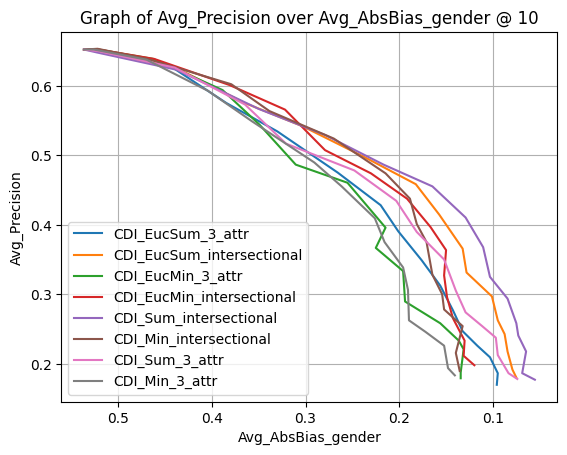

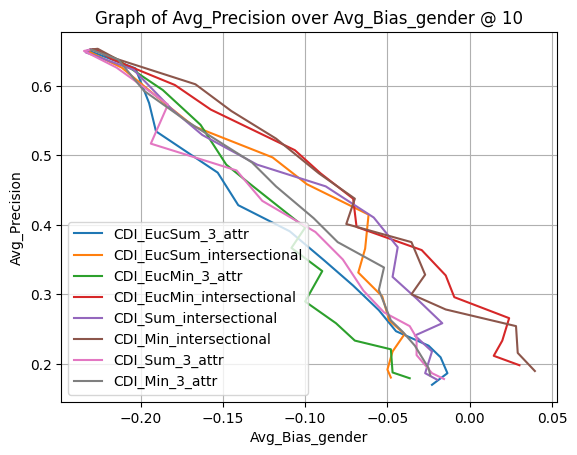

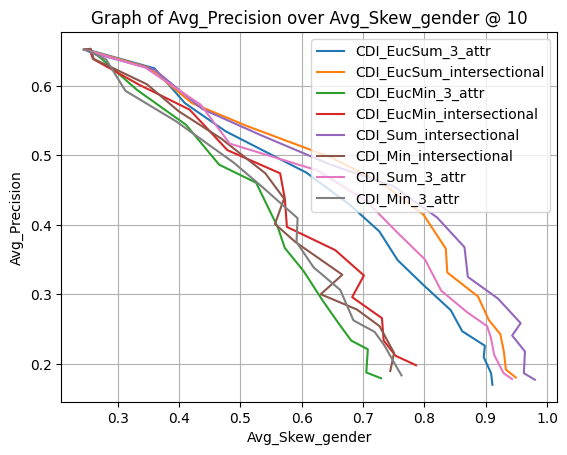

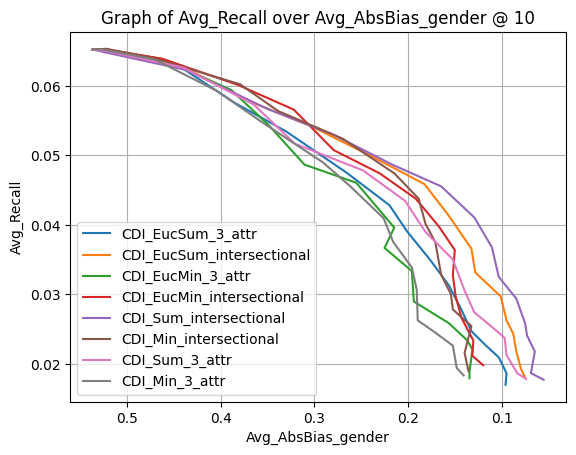

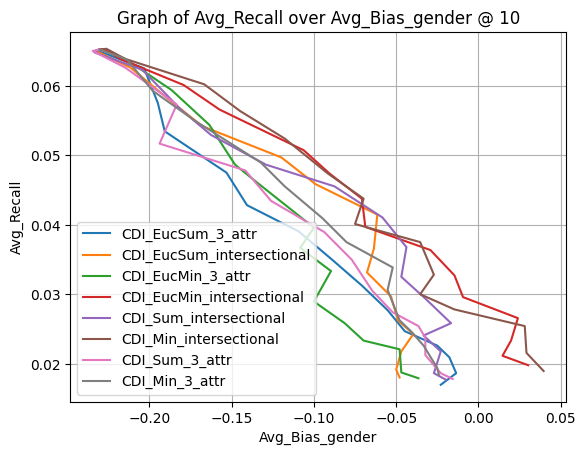

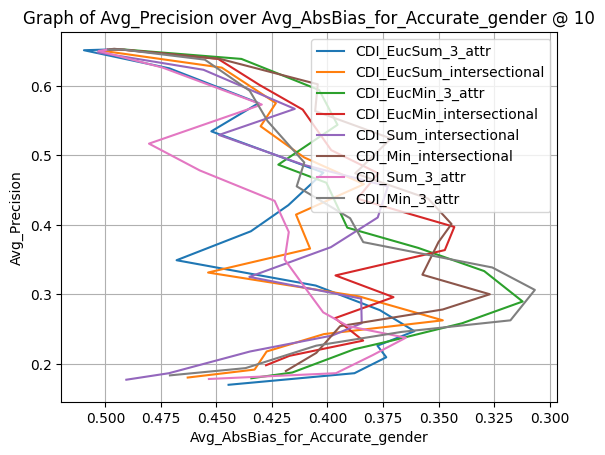

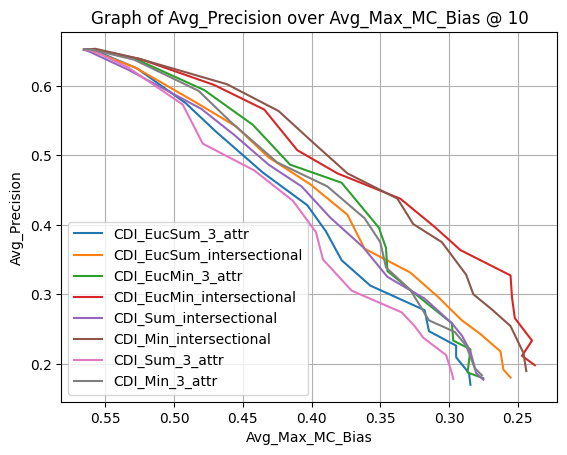

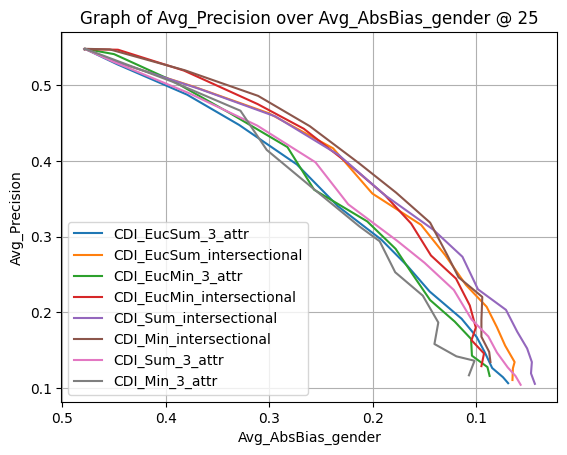

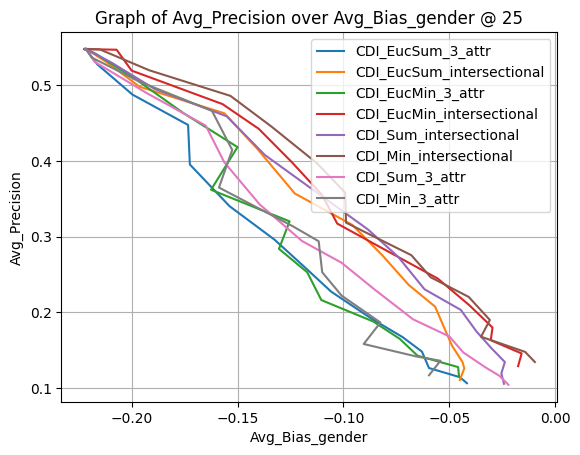

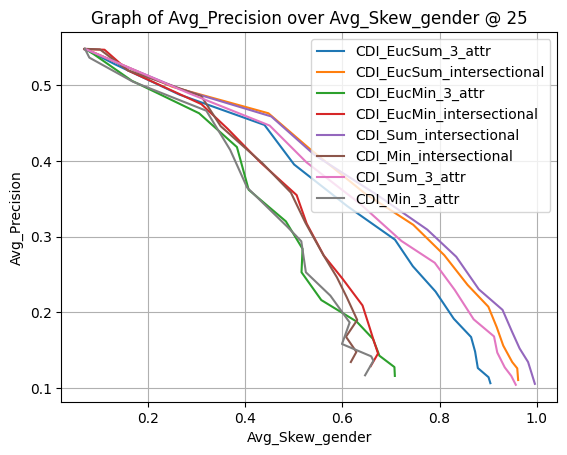

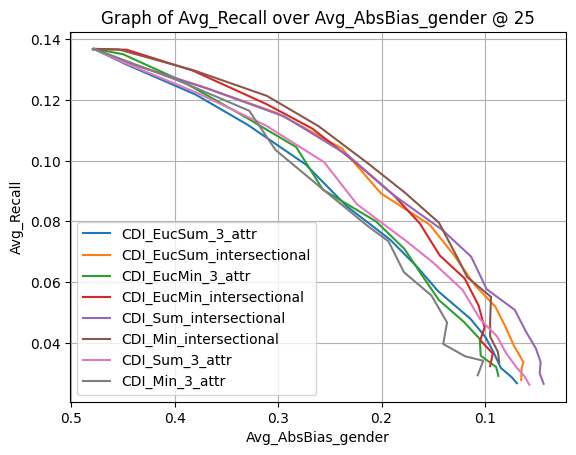

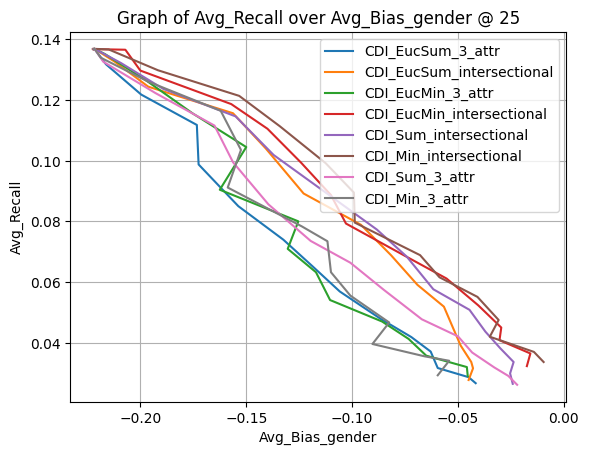

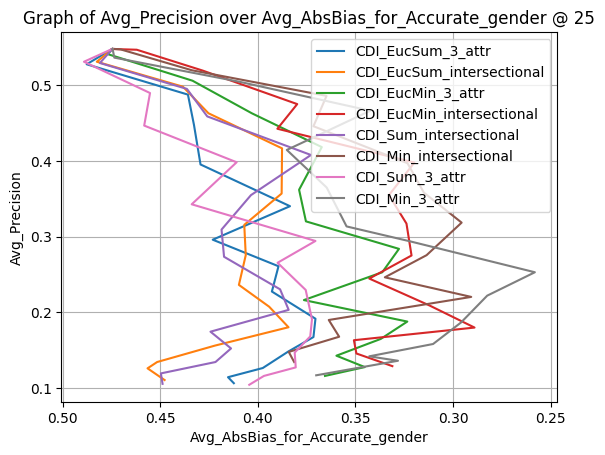

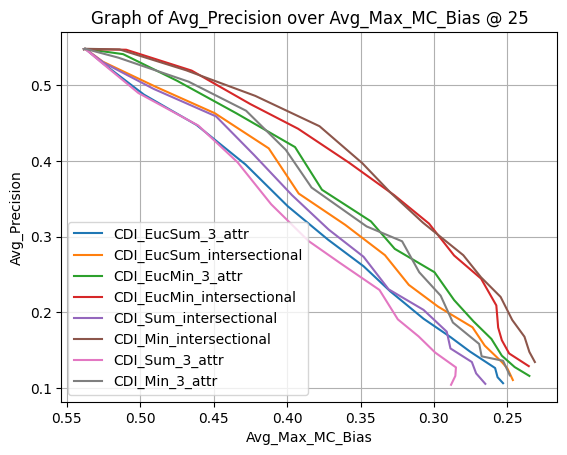

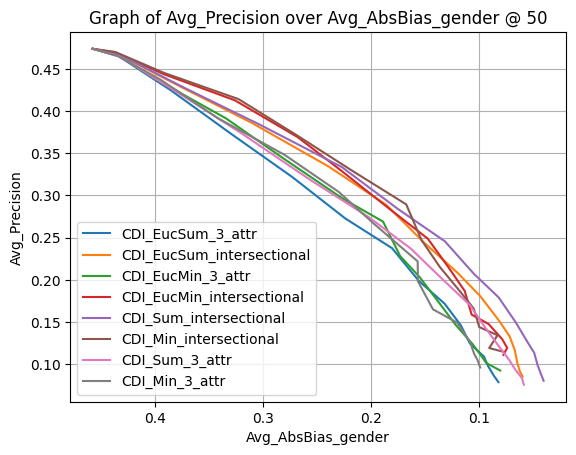

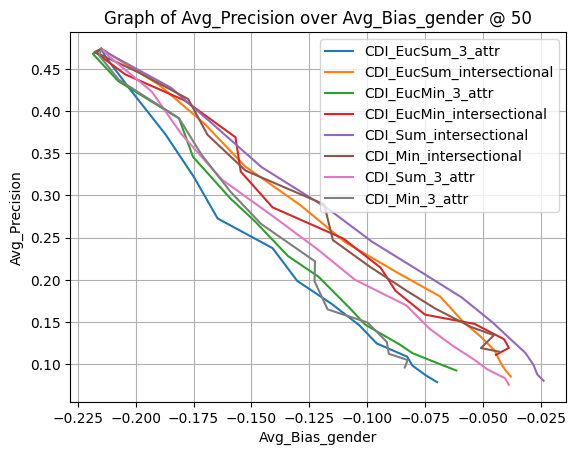

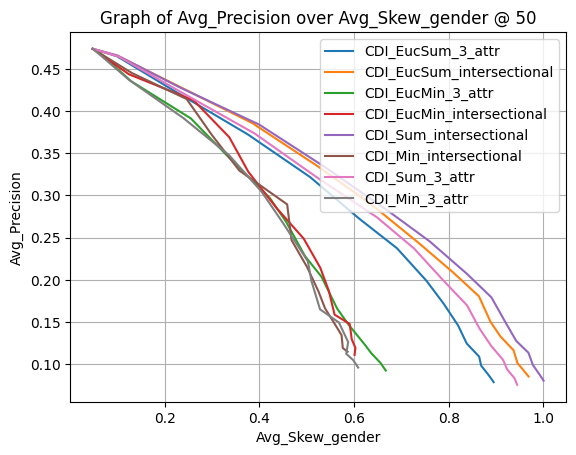

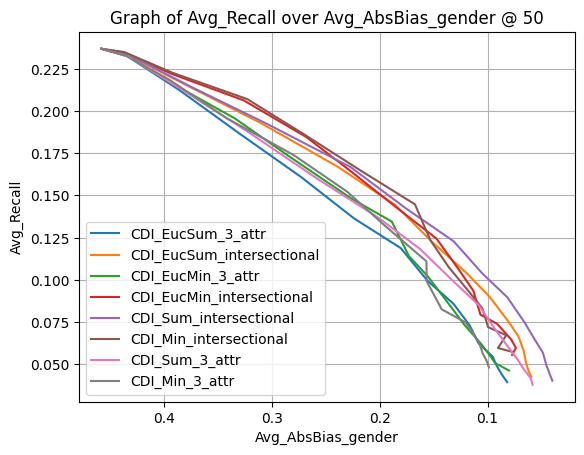

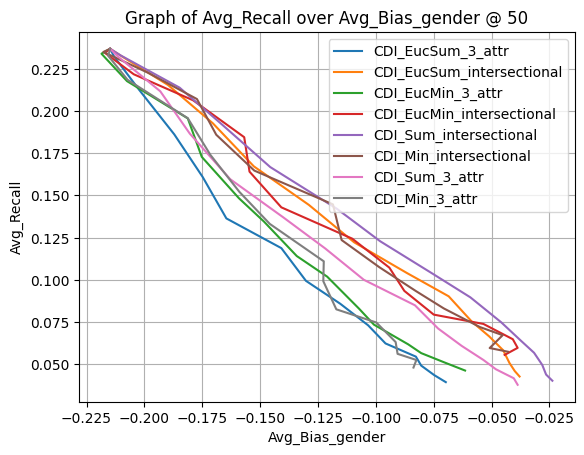

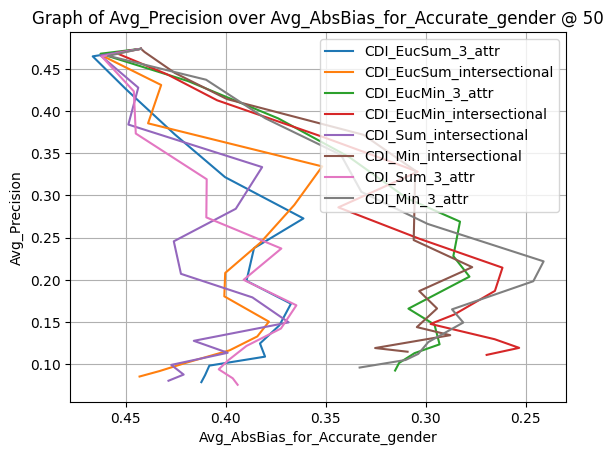

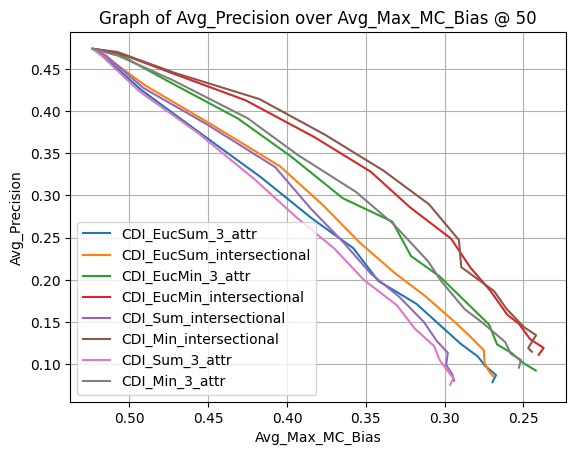

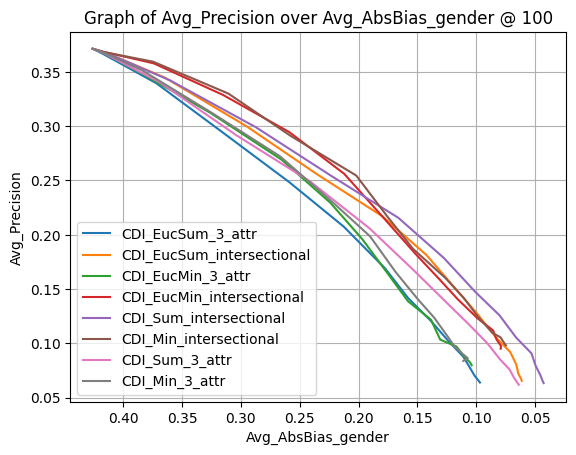

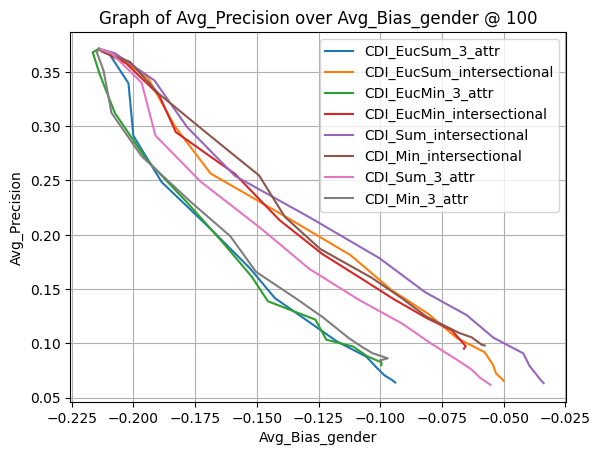

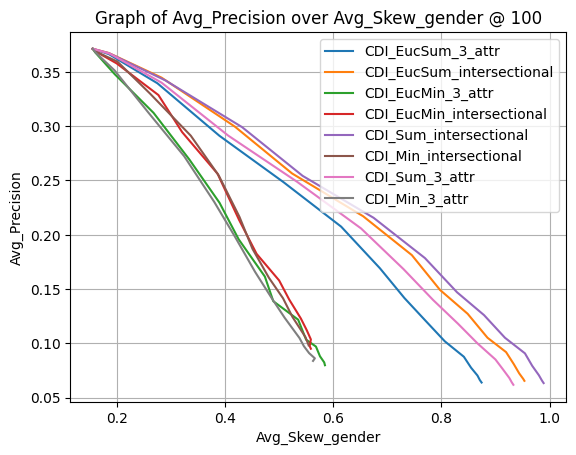

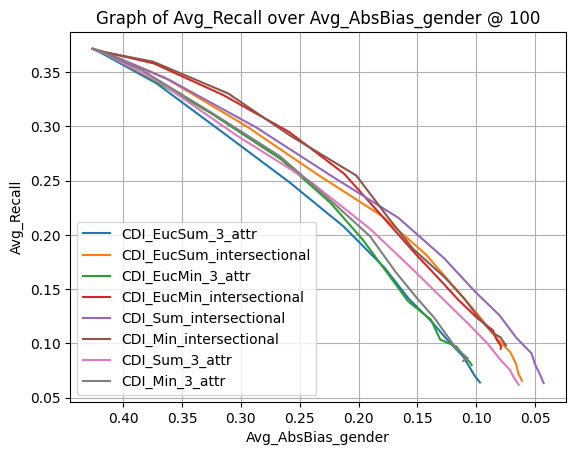

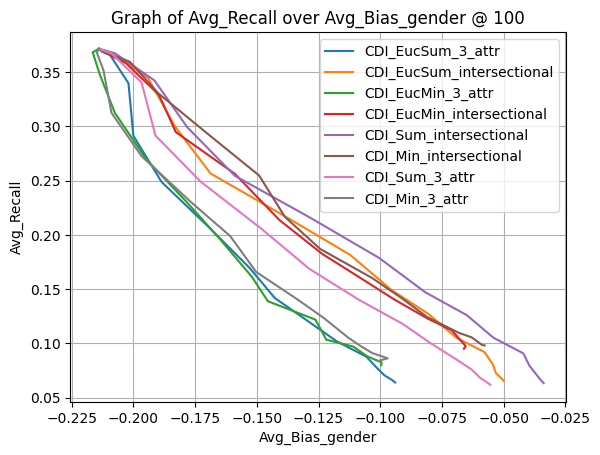

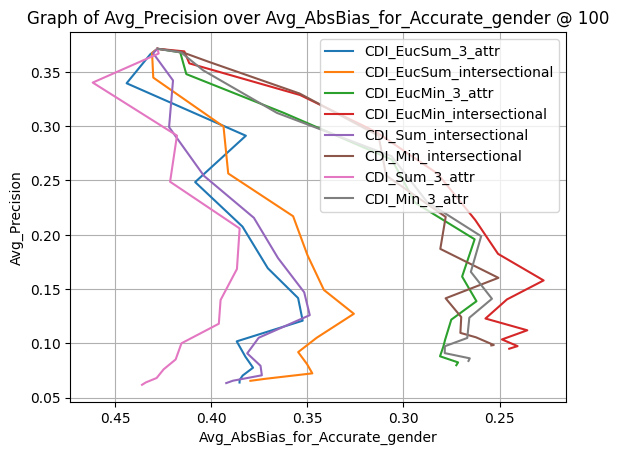

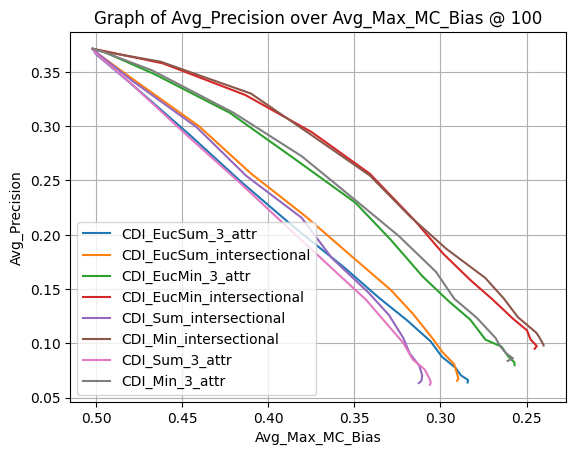

In [25]:
print(df3)
method_names += ['CDI_Sum_intersectional', 'CDI_Min_intersectional', 'CDI_Sum_3_attr', 'CDI_Min_3_attr']

for k in [10, 25, 50, 100]:
    plot_across_tol(df3, k, method_names, 'Avg_AbsBias_gender', 'Avg_Precision', reverse_x=True)
    plot_across_tol(df3, k, method_names, 'Avg_Bias_gender', 'Avg_Precision', reverse_x=False)
    plot_across_tol(df3, k, method_names, 'Avg_Skew_gender', 'Avg_Precision', reverse_x=False)
    plot_across_tol(df3, k, method_names, 'Avg_AbsBias_gender', 'Avg_Recall', reverse_x=True)
    plot_across_tol(df3, k, method_names, 'Avg_Bias_gender', 'Avg_Recall', reverse_x=False)
    plot_across_tol(df3, k, method_names, 'Avg_AbsBias_for_Accurate_gender', 'Avg_Precision', reverse_x=True)
    plot_across_tol(df3, k, method_names, 'Avg_Max_MC_Bias', 'Avg_Precision', reverse_x=True)

{'garbage collector': 100, 'dental hygienist': 100, 'paralegal': 100, 'courier': 100, 'housekeeper': 100, 'carpenter': 100, 'nurse practitioner': 100, 'building painter': 100, 'building inspector': 100, 'barber': 100, 'lawyer': 100, 'tour guide': 100, 'logistician': 100, 'pharmacist': 100, 'bartender': 100, 'librarian': 100, 'tax collector': 100, 'hairdresser': 100, 'engineer': 100, 'flight attendant': 100, 'plumber': 100, 'biologist': 100, 'parking attendant': 100, 'claims adjuster': 100, 'truck driver': 100, 'cook': 100, 'counselor': 100, 'drafter': 100, 'photographer': 100, 'financial advisor': 100, 'baker': 100, 'chiropractor': 100, 'insurance sales agent': 100, 'architect': 100, 'groundskeeper': 100, 'taxi driver': 100, 'tax preparer': 100, 'exterminator': 100, 'veterinarians': 100, 'nurse': 100, 'dishwasher': 100, 'real estate agent': 100, 'announcer': 100, 'bill collector': 100, 'private investigator': 100, 'receptionist': 100, 'typist': 100, 'travel agent': 100, 'teller': 100, 

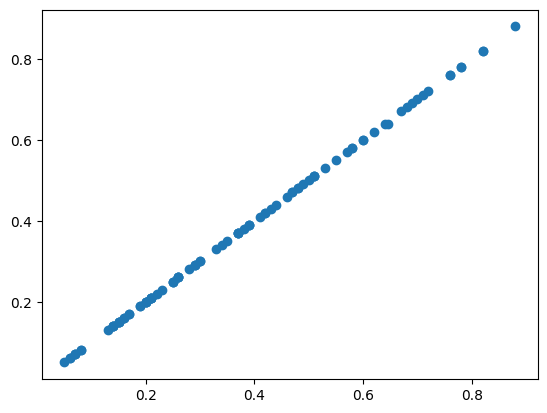

In [55]:
print(totals_by_cat)

recalls = []
precisions = []
for cat in catagories:
    res = image_database.clip_clip(f"This is a picture of a {cat}", "intersectional", 100, k=100)
    recalls.append(recall(label_column='search_term', positive_label_value=cat, data=res, total_positive=totals_by_cat[cat]))
    precisions.append(precision(label_column='search_term', positive_label_value=cat, data=res))

plt.scatter(recalls, precisions)
plt.show()

Starting analysis for k: 10...
Method: max_sum...


100%|██████████| 15/15 [21:10<00:00, 84.69s/it] 


Method: max_min...


100%|██████████| 15/15 [39:07<00:00, 156.49s/it]


Method: random...


100%|██████████| 15/15 [40:04<00:00, 160.28s/it]


Method: PBM_gender...


11it [00:53,  4.85s/it]


Method: PBM_skintone...


11it [00:53,  4.83s/it]


Method: PBM_intersectional...


11it [01:03,  5.73s/it]


Computing Baseline...
Computing Debias-Prompt...


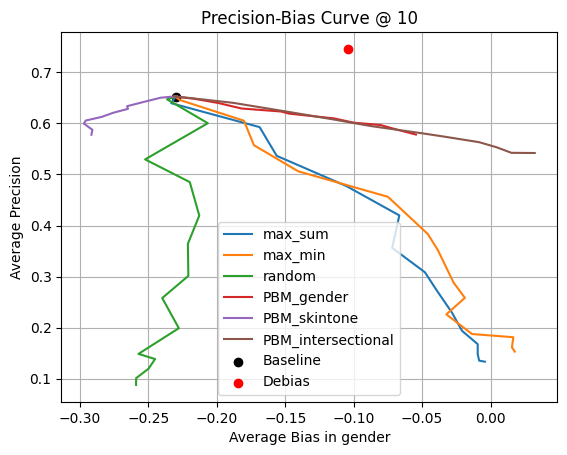

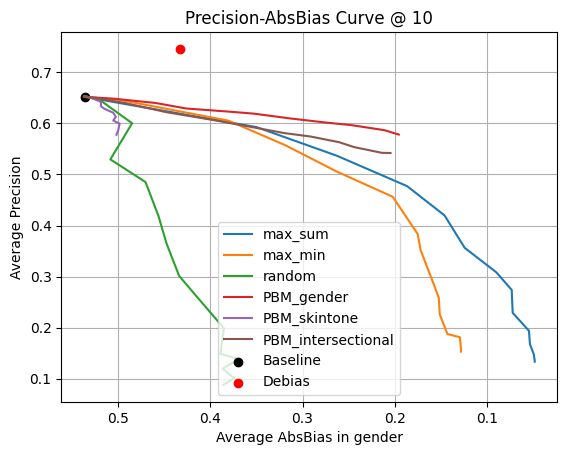

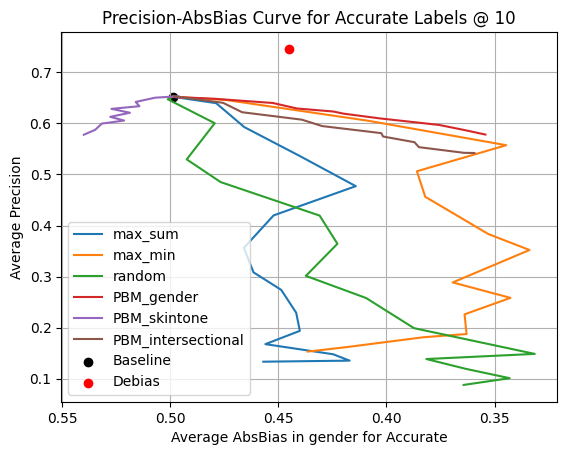

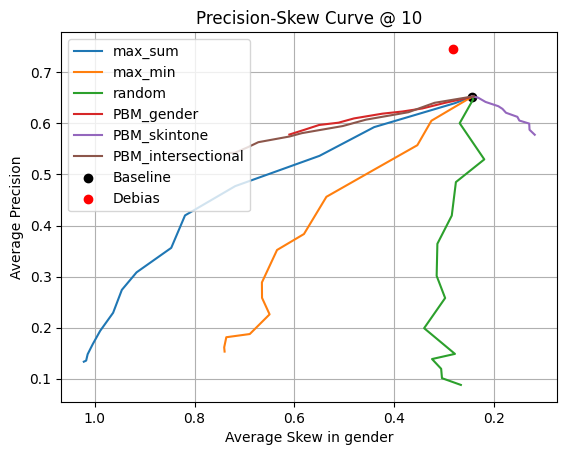

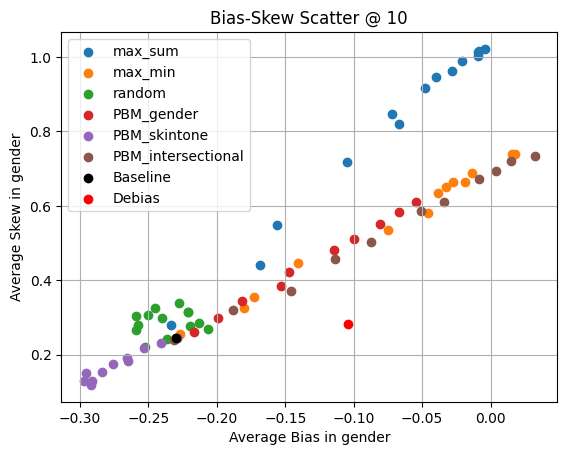

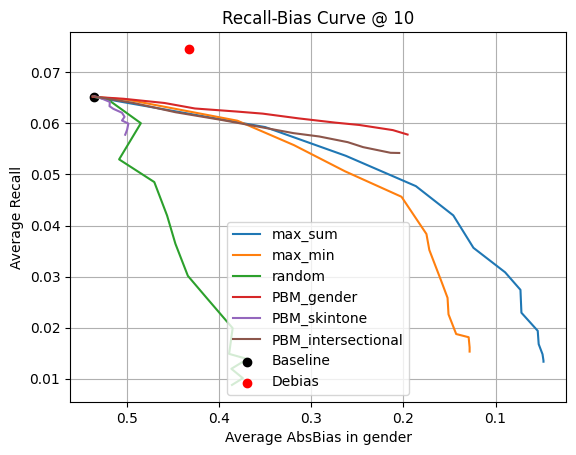

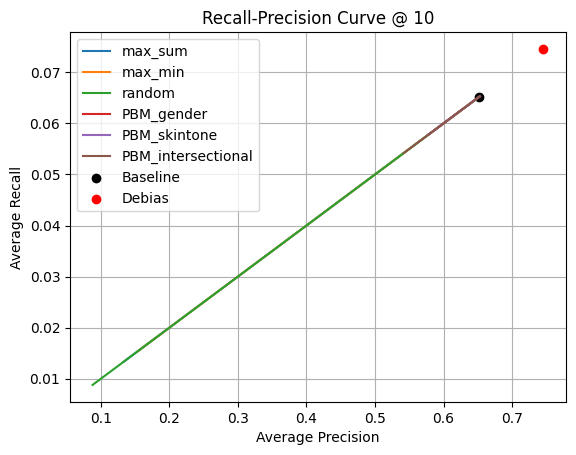

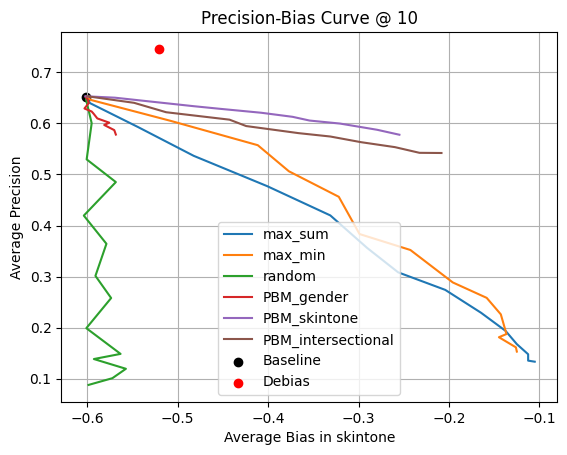

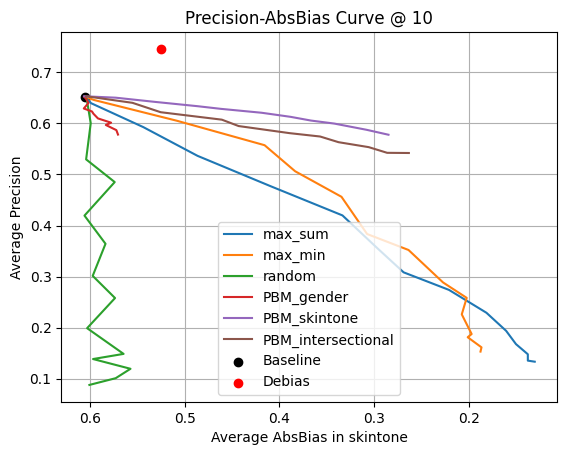

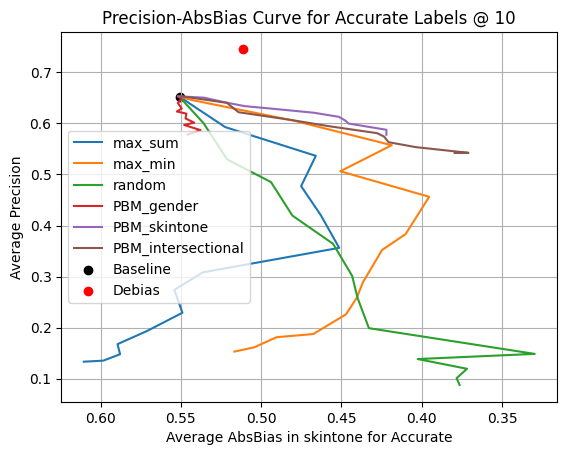

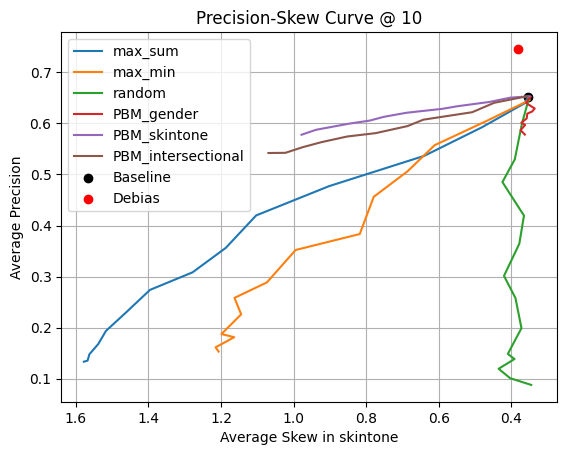

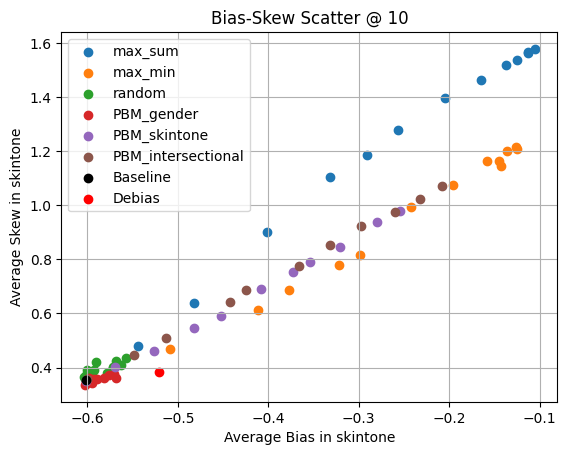

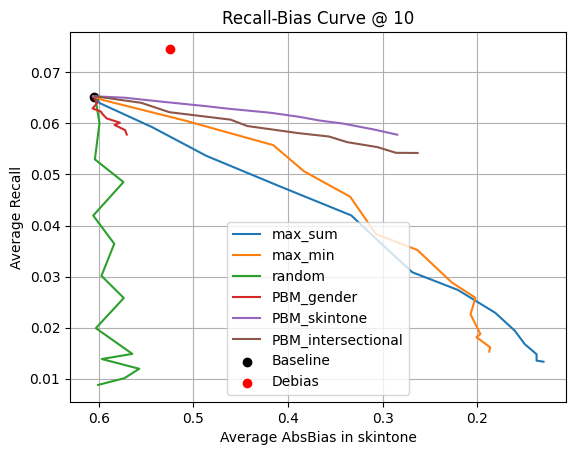

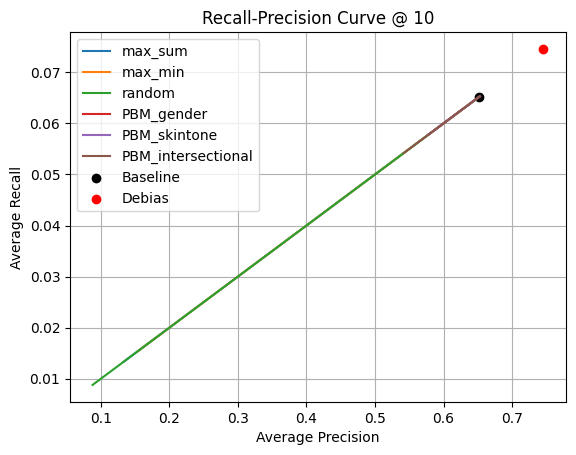

Starting analysis for k: 25...
Method: max_sum...


100%|██████████| 15/15 [20:51<00:00, 83.42s/it] 


Method: max_min...


100%|██████████| 15/15 [20:31<00:00, 82.09s/it] 


Method: random...


100%|██████████| 15/15 [1:02:16<00:00, 249.13s/it]


Method: PBM_gender...


11it [01:52, 10.21s/it]


Method: PBM_skintone...


11it [02:00, 10.93s/it]


Method: PBM_intersectional...


11it [02:29, 13.62s/it]


Computing Baseline...
Computing Debias-Prompt...


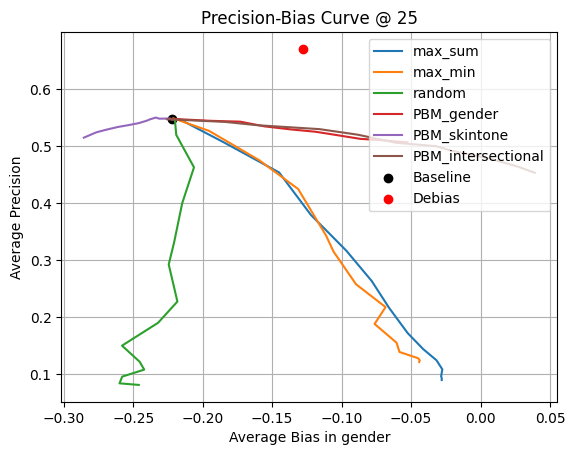

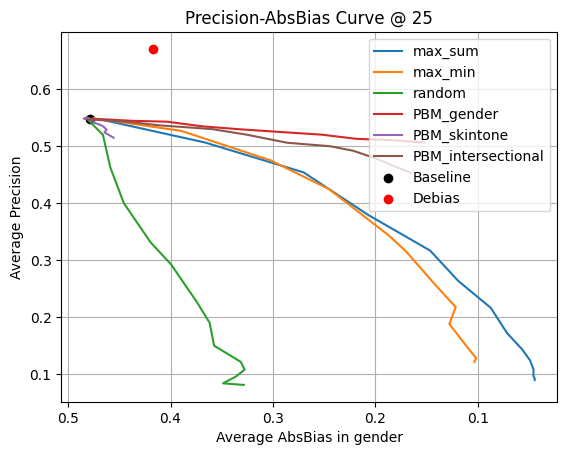

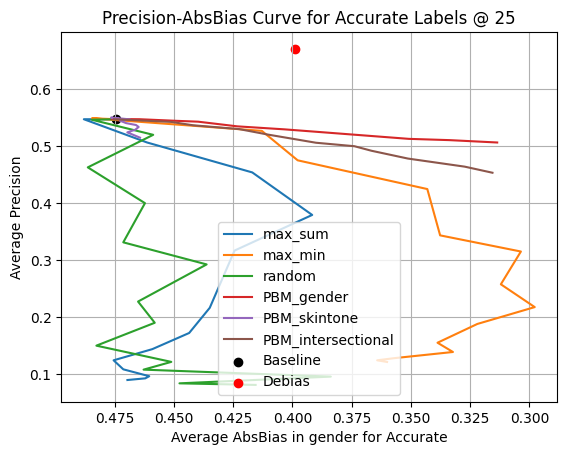

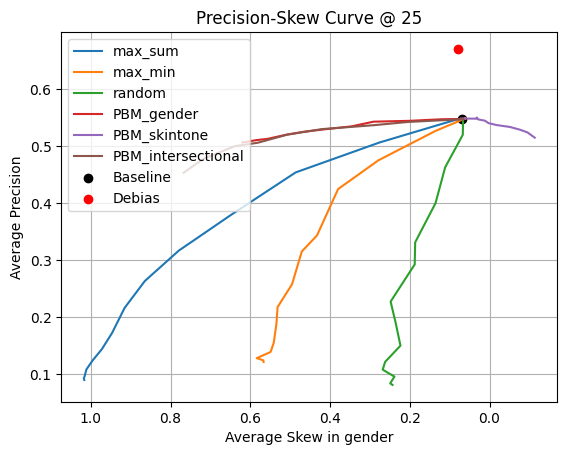

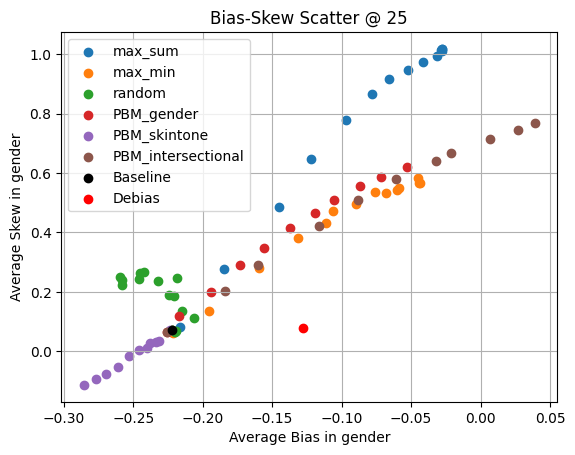

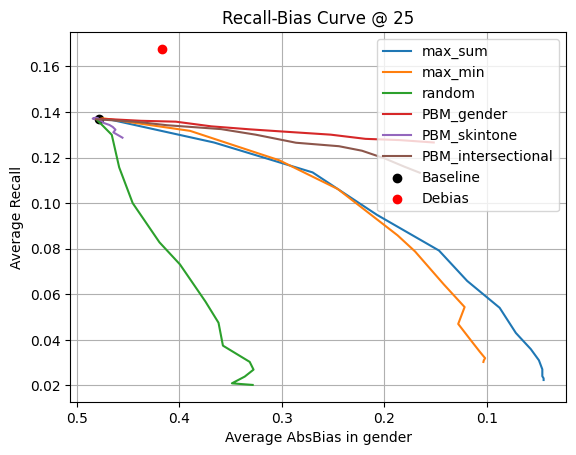

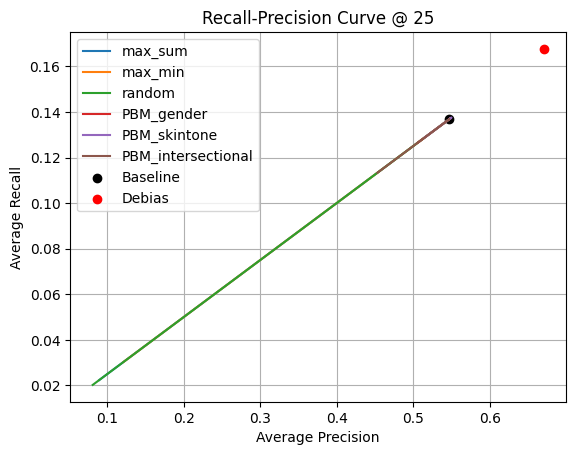

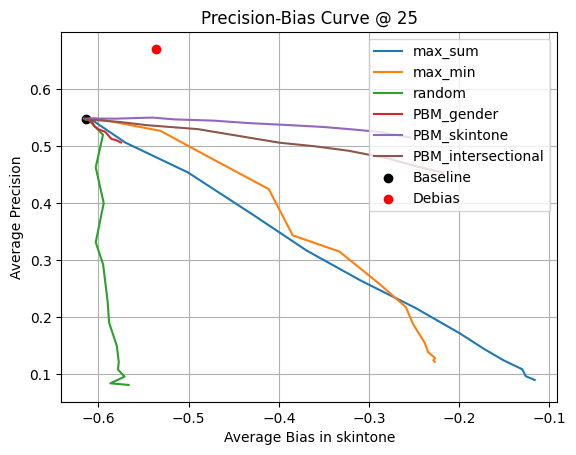

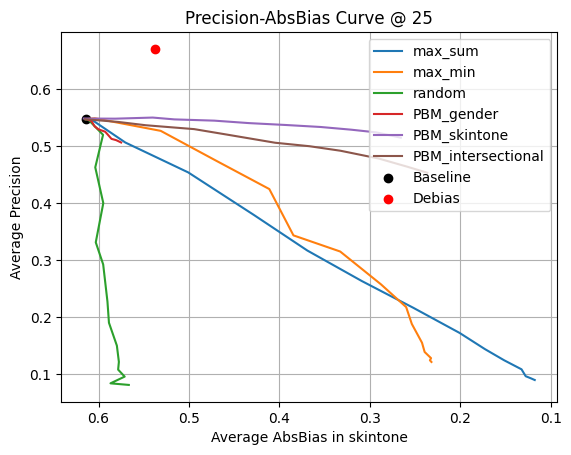

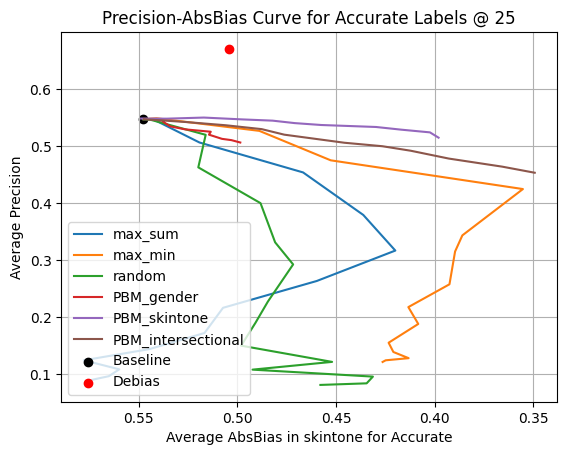

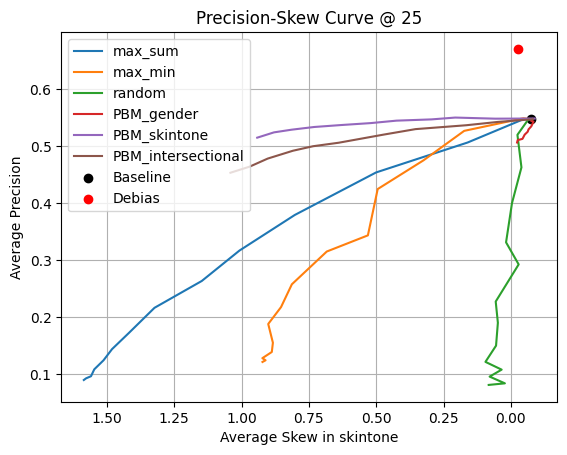

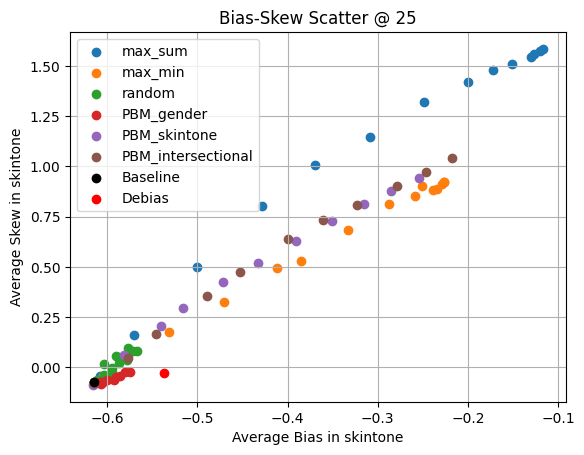

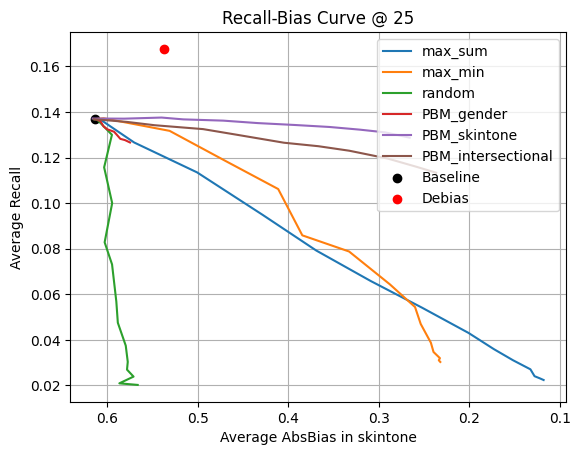

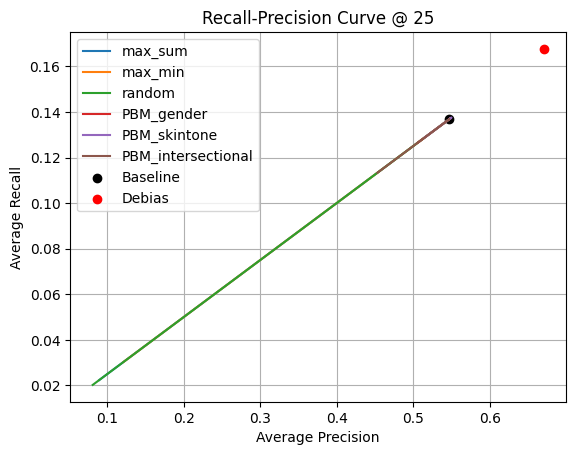

Starting analysis for k: 50...
Method: max_sum...


100%|██████████| 15/15 [34:06<00:00, 136.43s/it]


Method: max_min...


 93%|█████████▎| 14/15 [52:13<03:43, 223.82s/it]


KeyboardInterrupt: 

In [26]:
### For precision-precision graphs --

number_of_tol_steps = 15
methods = [
   'max_sum', 'max_min', 'random', 'PBM_gender', 'PBM_skintone', 'PBM_intersectional'
]

#methods = ['PBM', 'PBM_Intersectional']

image_database = ImageDatabase(features, data, model, preprocess, device)
image_database.sensitive_attributes([("A picture of a man", "A picture of a woman"), ("A picture of a white person", "A picture of a black person")])

debias_database = ImageDatabase(features_debias, data, model_debias, preprocess_debias, device_d)

random_iters = 3



for k in [10, 25, 50, 100]:
    print(f"Starting analysis for k: {k}...")
    precisions, biases, skews, abs_biases, abs_bias_for_accurate, recalls = {}, {}, {}, {}, {}, {}

    #max_skew = []
    #min_skew = []

    for method in methods:
        print(f"Method: {method}...")
        avg_precision = []
        avg_bias = []
        avg_skew = []
        avg_abs_bias = []
        avg_abs_bias_for_accurate = []
        avg_recall = []
        if method[0:3] == 'PBM':
            if method == 'PBM_gender':
                image_database.define_pbm_classes(["unknown gender", "man", "woman"])
            elif method == 'PBM_skintone':
                image_database.define_pbm_classes(["unknown skin-tone", "white person", "black person"])
            elif method == 'PBM_intersectional':
                image_database.define_pbm_classes(["unknown gender and skin-tone", "white man", "white woman", "black man", "black woman"])
            for eps in tqdm(reversed(range(0, 11))):
                mean_precision = 0
                mean_bias = 0
                mean_skew = 0
                mean_abs_bias = 0
                mean_abs_average_bias_for_accurate = 0
                mean_recall = 0
                for i in range(random_iters):
                    baseline_metrics = {}
                    run_analysis(lambda x: image_database.pbm(x, k, eps=eps/10), k, None, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
                    mean_precision += np.mean(baseline_metrics['precision'])
                    mean_bias += np.mean(baseline_metrics['bias'], axis=0)
                    mean_abs_bias += np.mean(baseline_metrics['abs_bias'], axis=0)
                    mean_skew += np.mean(baseline_metrics['skew'], axis=0)
                    mean_abs_average_bias_for_accurate += np.mean(baseline_metrics['abs_bias_for_accurate'], axis=0)
                    mean_recall += np.mean(baseline_metrics['recall'])

                avg_precision.append(mean_precision / random_iters)
                avg_bias.append(mean_bias / random_iters)
                avg_skew.append(mean_skew / random_iters)
                avg_abs_bias.append(mean_abs_bias / random_iters)
                avg_abs_bias_for_accurate.append(mean_abs_average_bias_for_accurate / random_iters)
                avg_recall.append(mean_recall / random_iters)
                gc.collect()
                torch.cuda.empty_cache()

        else:
            for tol in tqdm(range(0, number_of_tol_steps)):
                baseline_metrics = {}
                gc.collect()
                torch.cuda.empty_cache()
                t = tol / (10 * (number_of_tol_steps-1))
                ## This is inefficient write a faster way to vary tol and rerun the analysis
                if method == 'random':
                    mean_precision = 0
                    mean_bias = 0
                    mean_skew = 0
                    mean_abs_bias = 0
                    mean_abs_average_bias_for_accurate = 0
                    mean_recall = 0
                    for i in range(random_iters):
                        baseline_metrics = {}
                        run_analysis(lambda x: image_database.distinct_retrival(x, k, tol=t, method=method), k, t, baseline_metrics, catagories, 'search_term', indistinguisable_values,  ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
                        mean_bias += np.mean(baseline_metrics['bias'], axis=0)
                        mean_skew += np.mean(baseline_metrics['skew'], axis=0)
                        mean_abs_bias += np.mean(baseline_metrics['abs_bias'], axis=0)
                        mean_abs_average_bias_for_accurate += np.mean(baseline_metrics['abs_bias_for_accurate'], axis=0)
                        mean_precision += np.mean(baseline_metrics['precision'])
                        mean_recall += np.mean(baseline_metrics['recall'])
                    avg_precision.append(mean_precision/random_iters)
                    avg_bias.append(mean_bias/random_iters)
                    avg_skew.append(mean_skew/random_iters)
                    avg_abs_bias.append(mean_abs_bias/random_iters)
                    avg_abs_bias_for_accurate.append(mean_abs_average_bias_for_accurate/random_iters)
                    avg_recall.append(mean_recall/random_iters)
                    gc.collect()
                    torch.cuda.empty_cache()
                else:
                    run_analysis(lambda x: image_database.distinct_retrival(x, k, tol=t, method=method), k, t, baseline_metrics, catagories, 'search_term', indistinguisable_values,  ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
                    avg_precision.append(np.mean(baseline_metrics['precision']))
                    avg_bias.append(np.mean(baseline_metrics['bias'], axis=0))
                    avg_skew.append(np.mean(baseline_metrics['skew'], axis=0))
                    avg_abs_bias.append(np.mean(baseline_metrics['abs_bias'], axis=0))
                    avg_abs_bias_for_accurate.append(np.mean(baseline_metrics['abs_bias_for_accurate'], axis=0))
                    avg_recall.append(np.mean(baseline_metrics['recall']))
                
                #max_skew.append(np.mean(divimage_metrics['max_skew']))
                #min_skew.append(np.mean(divimage_metrics['min_skew']))
        precisions[method] = avg_precision
        biases[method] = avg_bias
        skews[method] = avg_skew
        abs_biases[method] = avg_abs_bias
        abs_bias_for_accurate[method] = avg_abs_bias_for_accurate
        recalls[method] = avg_recall

    print("Computing Baseline...")
    baseline_metrics = {}
    run_analysis(lambda x: image_database.search(x, k), k, None, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
    baseline_precision = np.mean(baseline_metrics['precision'])
    baseline_bias = np.mean(baseline_metrics['bias'], axis=0)
    baseline_skew = np.mean(baseline_metrics['skew'], axis=0)
    baseline_abs_bias = np.mean(baseline_metrics['abs_bias'], axis=0) 
    baseline_abs_bias_for_accurate = np.mean(baseline_metrics['abs_bias_for_accurate'], axis=0)
    baseline_recall = np.mean(baseline_metrics['recall'])


    print("Computing Debias-Prompt...")
    debias_metrics = {}
    run_analysis(lambda x: debias_database.search(x, k), k, None, debias_metrics, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
    debias_precision = np.mean(debias_metrics['precision'])
    debias_bias = np.mean(debias_metrics['bias'], axis=0)
    debias_skew = np.mean(debias_metrics['skew'], axis=0)
    debias_abs_bias = np.mean(debias_metrics['abs_bias'], axis=0)
    debias_abs_bias_for_accurate = np.mean(debias_metrics['abs_bias_for_accurate'], axis=0)
    debias_recall = np.mean(debias_metrics['recall'])

    for i, attribute in enumerate(['gender', 'skintone']):
        for method in methods:
            plt.plot(unpack_to_i(biases[method], i), precisions[method], label=method)
        plt.scatter(unpack_to_i(baseline_bias, i), baseline_precision, label='Baseline', color = 'black')
        plt.scatter(unpack_to_i(debias_bias, i), debias_precision, label='Debias', color = 'red')
        plt.grid()
        plt.xlabel(f"Average Bias in {attribute}")
        plt.ylabel("Average Precision")
        #plt.gca().invert_xaxis()
        plt.title(f"Precision-Bias Curve @ {k}")
        plt.legend()
        plt.show()

        for method in methods:
            plt.plot(unpack_to_i(abs_biases[method], i), precisions[method], label=method)
        plt.scatter(unpack_to_i(baseline_abs_bias, i), baseline_precision, label='Baseline', color = 'black')
        plt.scatter(unpack_to_i(debias_abs_bias, i), debias_precision, label='Debias', color = 'red')
        plt.grid()
        plt.xlabel(f"Average AbsBias in {attribute}")
        plt.ylabel("Average Precision")
        plt.gca().invert_xaxis()
        plt.title(f"Precision-AbsBias Curve @ {k}")
        plt.legend()
        plt.show()

        for method in methods:
            plt.plot(unpack_to_i(abs_bias_for_accurate[method], i), precisions[method], label=method)
        plt.scatter(unpack_to_i(baseline_abs_bias_for_accurate, i), baseline_precision, label='Baseline', color = 'black')
        plt.scatter(unpack_to_i(debias_abs_bias_for_accurate, i), debias_precision, label='Debias', color = 'red')
        plt.grid()
        plt.xlabel(f"Average AbsBias in {attribute} for Accurate")
        plt.ylabel("Average Precision")
        plt.gca().invert_xaxis()
        plt.title(f"Precision-AbsBias Curve for Accurate Labels @ {k}")
        plt.legend()
        plt.show()


        for method in methods:
            plt.plot(unpack_to_i(skews[method], i), precisions[method], label=method)
        plt.scatter(unpack_to_i(baseline_skew, i), baseline_precision, label='Baseline', color='black')
        plt.scatter(unpack_to_i(debias_skew, i), debias_precision, label='Debias', color='red')
        plt.grid()
        plt.xlabel(f"Average Skew in {attribute}")
        plt.ylabel(f"Average Precision")
        plt.gca().invert_xaxis()

        plt.title(f"Precision-Skew Curve @ {k}")
        plt.legend()
        plt.show()

        for method in methods:
            plt.scatter(unpack_to_i(biases[method], i), unpack_to_i(skews[method], i), label=method)
        plt.scatter(unpack_to_i(baseline_bias, i), unpack_to_i(baseline_skew, i), label='Baseline', color='black')
        plt.scatter(unpack_to_i(debias_bias, i), unpack_to_i(debias_skew, i), label='Debias', color='red')
        plt.legend()
        plt.grid()
        plt.ylabel(f"Average Skew in {attribute}")
        plt.xlabel(f"Average Bias in {attribute}")
        plt.title(f"Bias-Skew Scatter @ {k}")
        plt.show()

        for method in methods:
            plt.plot(unpack_to_i(abs_biases[method], i), recalls[method], label=method)
        plt.scatter(unpack_to_i(baseline_abs_bias, i), baseline_recall, label='Baseline', color = 'black')
        plt.scatter(unpack_to_i(debias_abs_bias, i), debias_recall, label='Debias', color = 'red')
        plt.grid()
        plt.xlabel(f"Average AbsBias in {attribute}")
        plt.ylabel("Average Recall")
        plt.gca().invert_xaxis()
        plt.title(f"Recall-Bias Curve @ {k}")
        plt.legend()
        plt.show()

        for method in methods:
            plt.plot(precisions[method], recalls[method], label=method)
        plt.scatter(baseline_precision, baseline_recall, label='Baseline', color = 'black')
        plt.scatter(debias_precision, debias_recall, label='Debias', color = 'red')
        plt.grid()
        plt.xlabel(f"Average Precision")
        plt.ylabel("Average Recall")
        plt.title(f"Recall-Precision Curve @ {k}")
        plt.legend()
        plt.show()


    




In [ ]:
attr = [("A picture of a man", "A picture of a woman"), ("A picture of a white person", "A picture of a black person"), ("A picture of a young person", "A picture of an old person"), ("A picture of an American Person", "A picture of a non-American person"), ("A picture of a disabled person", "A picture of a person who is not disabled")]
image_database = ImageDatabase(features, data, model, preprocess, device)
k = [10, 25, 50]
number_of_tol_steps = 20

for k in k:
    precisions, biases, skews = {}, {}, {}
    for i in range(len(attr)):
        avg_precision = []
        avg_bias = []
        image_database.sensitive_attributes(attr[:i+1])
        for tol in range(0, number_of_tol_steps):
            baseline_metrics = {}
            t = tol / (10 * (number_of_tol_steps-1))
            run_analysis(lambda x: image_database.distinct_retrival(x, k, tol=t, method='max_sum'), k, t, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates)
            avg_bias.append(np.mean(baseline_metrics['abs_bias'], axis=0))
            avg_precision.append(np.mean(baseline_metrics['precision']))
        precisions[str(i)] = avg_precision
        biases[str(i)] = avg_bias


    baseline_metrics = {}
    run_analysis(lambda x: image_database.search(x, k), k, None, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates)
    baseline_precision = np.mean(baseline_metrics['precision'])
    baseline_bias = np.mean(baseline_metrics['abs_bias'], axis=0)
    baseline_skew = np.mean(baseline_metrics['skew'])

    for i in range(len(attr)):
        plt.plot(unpack_to_i(biases[str(i)], 0), precisions[str(i)], label=("Total unmeasured cats: " + str(i)))
    plt.scatter(unpack_to_i(baseline_bias, 0), baseline_precision, label='Baseline')
    plt.grid()
    plt.xlabel("Average AbsBias on Gender")
    plt.ylabel("Average Precision")
    plt.gca().invert_xaxis()
    plt.title(f"Precision-AbsBias Curve @ {k}")
    plt.legend()
    plt.show()

    
    for i in range(len(attr)):
        plt.plot(unpack_to_i(biases[str(i)], 1), precisions[str(i)], label=("Total unmeasured cats: " + str(i)))
    plt.scatter(unpack_to_i(baseline_bias, 1), baseline_precision, label='Baseline')
    plt.grid()
    plt.xlabel("Average AbsBias on Skin-Tone")
    plt.ylabel("Average Precision")
    plt.gca().invert_xaxis()
    plt.title(f"Precision-AbsBias Curve @ {k}")
    plt.legend()
    plt.show()

            

In [ ]:
attributes = [
    [("A picture of a man.", "A picture of a woman."), ("A picture of a white person", "A picture of a black person")],
    [("A picture of a man.", "A picture of a woman."), ("A picture of a white person", "A picture of a black person"), ("A picture of a white person", "A picture of a hispanic person"), ("A picture of a white person", "A picture of an asian person"), ("A picture of a white person", "A picture of a mixed-race person"), ("A picture of a white person", "A picture of a native-american person or pacific islander")],
    [("A picture of a man.", "A picture of a woman."), ("A picture of a light-skinned person", "A picture of a dark-skinned person")]
]

labels = [
    "White vs Black",
    "Different Ethnicities",
    "Skin-tone"
]

k = [10, 25, 50]
number_of_tol_steps = 15

for k in k:
    precisions, biases, skews = {}, {}, {}
    for i in range(len(attributes)):
        avg_precision = []
        avg_bias = []
        image_database.sensitive_attributes(attributes[i])
        for tol in tqdm(range(0, number_of_tol_steps)):
            baseline_metrics = {}
            t = tol / (10 * (number_of_tol_steps-1))
            run_analysis(lambda x: image_database.distinct_retrival(x, k, tol=t, method='max_sum'), k, t, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates)
            avg_bias.append(np.mean(baseline_metrics['abs_bias'], axis=0))
            avg_precision.append(np.mean(baseline_metrics['precision']))
        precisions[str(i)] = avg_precision
        biases[str(i)] = avg_bias

    for i in range(len(attributes)):
        plt.plot(unpack_to_i(biases[str(i)], 1), precisions[str(i)], label=(labels[i]))
    plt.grid()
    plt.xlabel("Average AbsBias on Skin-Tone")
    plt.ylabel("Average Precision")
    plt.gca().invert_xaxis()
    plt.title(f"Precision-AbsBias Curve @ {k}")
    plt.legend()
    plt.show()
